In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import IPython
from IPython.display import HTML

import tensorflow as tf
import keras
from keras.layers import Input
from keras.models import Model, load_model

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import matplotlib.tri as tri
font = {'size'   : 21}
matplotlib.rc('font', **font)
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation

from joblib import load

/zeus/zeus_scr/agar_si/python/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/zeus/zeus_scr/agar_si/python/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/zeus/zeus_scr/agar_si/python/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/zeus/zeus_scr/agar_si/python/a

In [2]:
class RegressionLSTM:
    def __init__(self):
        
        dictToOpen = "results/Dict_processed_data_MarsNew_2D_ConvLSTM_T_[12000]sims_1channel_ae840_0p98tr_wt.txt" 
        with open(dictToOpen, "rb") as myFile:
            Dict_processed_data = load(myFile)

        self.xCoords = Dict_processed_data['x'] 
        self.yCoords = Dict_processed_data['y'] 
        self.yMin = Dict_processed_data['postEncodedOMin'] 
        self.yMax = Dict_processed_data['postEncodedOMax']
        self.xMin = Dict_processed_data['paraMin'] 
        self.xMax = Dict_processed_data['paraMax']
        
        self.xMin.append(self.xMin.pop(0))
        self.xMax.append(self.xMax.pop(0))
                
        tf.keras.backend.clear_session()
        
        self.oMax = 1.1985519218679175 
        self.oMin = 0.
        
    def LSTM(self, _hSize, _parameters, CreateAnimation, CreatePlots):
        
        numLevels=32
        v_max=1.2
        v_min=0.4
        levels=np.linspace(v_min,v_max,numLevels)
        
        cmapName = 'inferno'
        
        x_ = self.xCoords
        y_ = self.yCoords 
        min_radius = x_[0]
        triang = tri.Triangulation(x_, y_)
        triang.set_mask(np.hypot(x_[triang.triangles].mean(axis=1),y_[triang.triangles].mean(axis=1))< min_radius)
        
        def nondimensionalize(d, dMax, dMin):
            return (d-dMin)/(dMax-dMin)
        
        def dimensionalize(d, dMax, dMin):
            return (d*(dMax-dMin))+dMin
        
        graph = tf.get_default_graph()
        
        config = tf.ConfigProto(
        intra_op_parallelism_threads=1,
        allow_soft_placement=True)

        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.8

        session0 = tf.Session(config=config)
        session1 = tf.Session(config=config)
        session2 = tf.Session(config=config)
        
        ae = ['T_Mars300_sims10k_f5A7s2_c3to24_tanh_l2reg_wlrsc', "conv2d_6", [5,7,24], -11]
        nameNN = _hSize
        nameAE = ae[0]
        timeSteps = 45
        e_h = ae[2][0]
        e_w = ae[2][1]
        e_l = ae[2][2]            
        e_size = e_h*e_w*e_l  
        
        #non-dimensionalize to Ra, E', V', T_ini'
        rho_m   = 3500. 
        g     = 3.7 
        alpha_m = 2.5e-5
        T_delta = 2000. 
        D = 1700e+3         
        k_diffusive = 1e-6 
        R = 8.314
        year_to_seconds = 365.25 * 24. * 3600.
        parameters = []
        for p in _parameters:
            parameters.append([rho_m * g * alpha_m * T_delta * np.power(D,3.)/(p[0] * k_diffusive),  \
                              p[1]/(R * T_delta), \
                              p[2]/(R * T_delta) * rho_m * g * D, \
                              p[3], \
                              (p[4]-250)/T_delta])
            
        #non-dimensionalize between 0 and 1
        for pInd, pVal in enumerate(parameters):
            for ppInd, ppVal in enumerate(pVal[:-1]):
                if ppInd==0:
                    ppVal = np.log10(ppVal)
                parameters[pInd][ppInd] = nondimensionalize(ppVal,self.xMax[ppInd+2],self.xMin[ppInd+2])
                              
        dataLSTM = np.zeros((len(parameters),timeSteps,e_size+8))
        
        for sInd in range(len(parameters)):
            dataLSTM[sInd,:,0] = 1
            dataLSTM[sInd,:,1] = nondimensionalize(self.xMax[-1]/timeSteps,self.xMax[1],self.xMin[1])
            for i in range(2,7):
                dataLSTM[sInd,:,i] = parameters[sInd][i-2]
            dataLSTM[sInd,:,7] = nondimensionalize(np.linspace(0,self.xMax[-1],timeSteps),self.xMax[-1],self.xMin[-1])
            
        with session0.as_default():
            with session0.graph.as_default():
                autoencoder = load_model('trainedNetworks/ConvAE/' + nameAE + '.hdf5')
                encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(ae[1]).output)
                
                sInd = 0
                for p in parameters:
                    dProf = np.linspace(0,1,302)
                    bl_ind = 53 #np.where(dProf>=bl_thic-tol and dProf<bl_thic+tol)[0][0]
                    iniTempField = np.zeros((1,302,394,1))
                    iniTempField[:,0:bl_ind,:,:] = np.linspace(1,p[-1],bl_ind).reshape(1,bl_ind,1,1)
                    iniTempField[:,bl_ind:-bl_ind,:,:] = p[-1]
                    iniTempField[:,-bl_ind:,:,:] = np.linspace(p[-1],0,bl_ind).reshape(1,bl_ind,1,1)                    
                    iniTempField = iniTempField/self.oMax
                    iniTempField = encoder.predict([iniTempField])
                    dataLSTM[sInd,0,8:] = nondimensionalize(iniTempField.flatten(),self.yMax,self.yMin)
                    sInd += 1
        
        prevTimeSteps = 20
        inputSize = 8
        
        with session1.as_default():
            with session1.graph.as_default():
                lstm = load_model('trainedNetworks/LSTM/' + nameNN +'.hdf5')
                lstm.summary()

                for sInd in range(len(parameters)):
                    for tInd in range(1,timeSteps):
                        seq = np.arange(tInd-prevTimeSteps,tInd)
                        for sind,sval in enumerate(seq):
                            if sval<0:
                                seq[sind] = 0
                        inputVec = np.zeros((1,prevTimeSteps,e_size+inputSize))
                        inputVec = dataLSTM[sInd,seq,:].reshape(1,prevTimeSteps,e_size+inputSize)
                        dataLSTM[sInd,seq[-1]+1,inputSize:] = lstm.predict(inputVec)

        with session2.as_default():
            with session2.graph.as_default():
                autoencoder = load_model('trainedNetworks/ConvAE/' + nameAE + '.hdf5')
                autoencoder.summary()
                encoded_input = Input(shape=(ae[2][0],ae[2][1],ae[2][2]))
                deco = encoded_input
                for l in range(ae[3],0):
                    deco = autoencoder.layers[l](deco)
                decoder = Model(encoded_input, deco)

                fulldataLSTM = np.zeros((len(parameters),timeSteps,302,394,1))  
                for sInd in range(len(parameters)):
                    for tInd in range(timeSteps):
                        temp = dimensionalize(dataLSTM[sInd,tInd,inputSize:],self.yMax,self.yMin)
                        temp.shape = (1,ae[2][0],ae[2][1],ae[2][2])
                        fulldataLSTM[sInd,tInd,:,:,:] = decoder.predict(temp)*self.oMax       
        
        for simInd in range(len(parameters)):               
            if CreateAnimation:
                fig = plt.figure(figsize=(4,4))
                ax = fig.add_subplot(1,1,1)                  
                ax.set_title('LSTM')
                def update(i):            
                    time = (dataLSTM[simInd,i,7]*(self.xMax[-1]-self.xMin[-1])+self.xMin[-1])/k_diffusive*np.power(D,2.)/(year_to_seconds*1e+9)
                    z = fulldataLSTM[simInd,i,:,:,:].flatten()
                    contg = ax.tricontourf(triang, z, extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                    ax.set_xlabel("$t_{" + str(i) + "} = " + str(np.round(time,2)) + "$ Gyr")
                    ax.set_xticks([0.33,0.83,1.33])
                    ax.set_yticks([0.33,0.83,1.33])
                    return contg

                anim = FuncAnimation(fig, update, frames=np.arange(timeSteps))
                plt.gcf().subplots_adjust(bottom=0.25,left=0.25)
                anim.save("results/Gifs/LSTM_" + str(_parameters[simInd]) + '.gif', dpi=200, writer='imagemagick')

            tol = 4.5/timeSteps
            if CreatePlots:
                for i in range(timeSteps):
                    z = fulldataLSTM[simInd,i,:,:,:]
                    mlProf = np.mean(z,axis=1)
                    
                    time = (dataLSTM[simInd,i,7]*(self.xMax[-1]-self.xMin[-1])+self.xMin[-1])/k_diffusive*np.power(D,2.)/(year_to_seconds*1e+9)
                    
                    if (time>=1-tol and time<=1+tol) or \
                       (time>=2-tol and time<=2+tol) or \
                       (time>=3-tol and time<=3+tol) or \
                       (time>=4.5-tol and time<=4.5+tol):
                        
                        fig = plt.figure(figsize=(8,4), dpi=320)

                        ax = fig.add_subplot(1,2,1) 

                        cax = ax.tricontourf(triang, z.flatten(), extend="both", vmax=v_max, vmin=v_min, levels=levels, cmap=cmapName)
                        ax.set_xlabel("Radius$'$")
                        ax.set_ylabel("Radius$'$")
                        ax.set_xticks([0.33,0.83,1.33])
                        ax.set_yticks([0.33,0.83,1.33])
                        ax.set_title("LSTM " + str(np.round(time,3))+ " Gyr")
                        #fig.colorbar(cax, ax=ax)

                        ax = fig.add_subplot(1,2,2)
                        rprof = np.linspace(0.33,1.33,302)
                        ax.plot(mlProf,rprof,'r--',linewidth=3.5)
                        #ax.legend(["GAIA", "NN"])
                        ax.set_xlabel("Temperature$'$")
                        ax.set_yticks([0.33,0.83,1.33])

                        plt.tight_layout(pad=0.1)
                        plt.show()        


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 848)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 600)           3477600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 600)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 600)           2882400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 600)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 600)           2882400   
______________________________

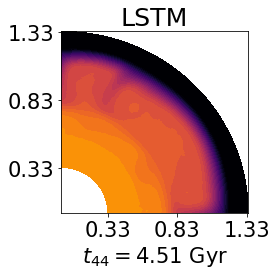

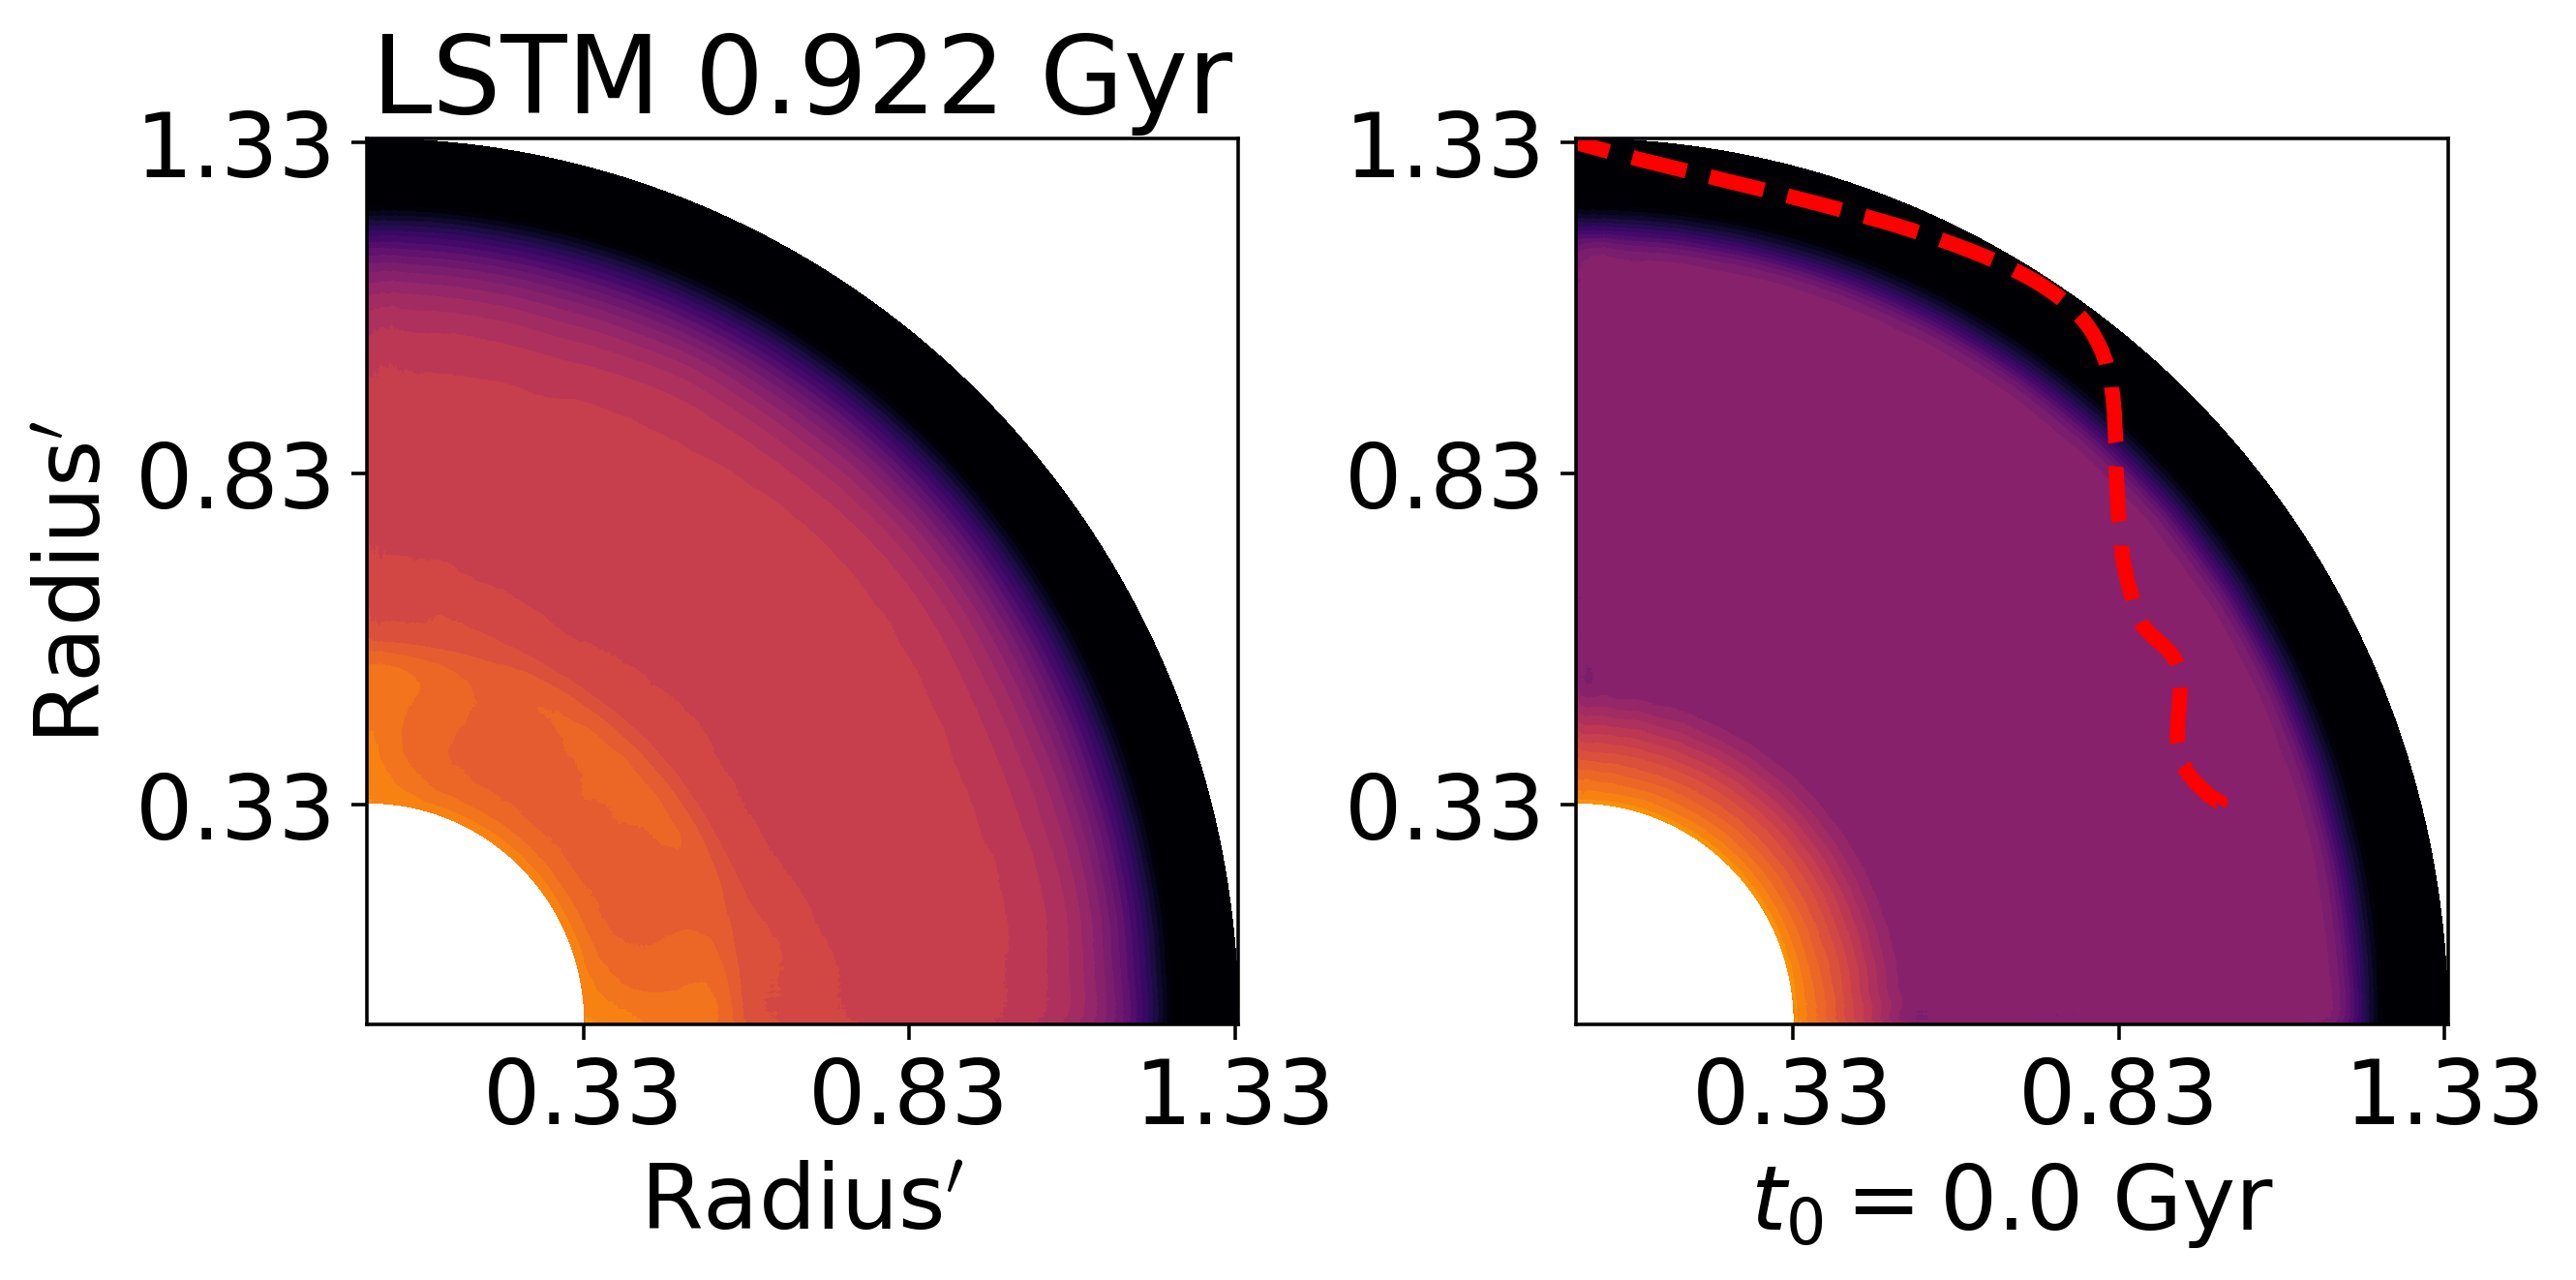

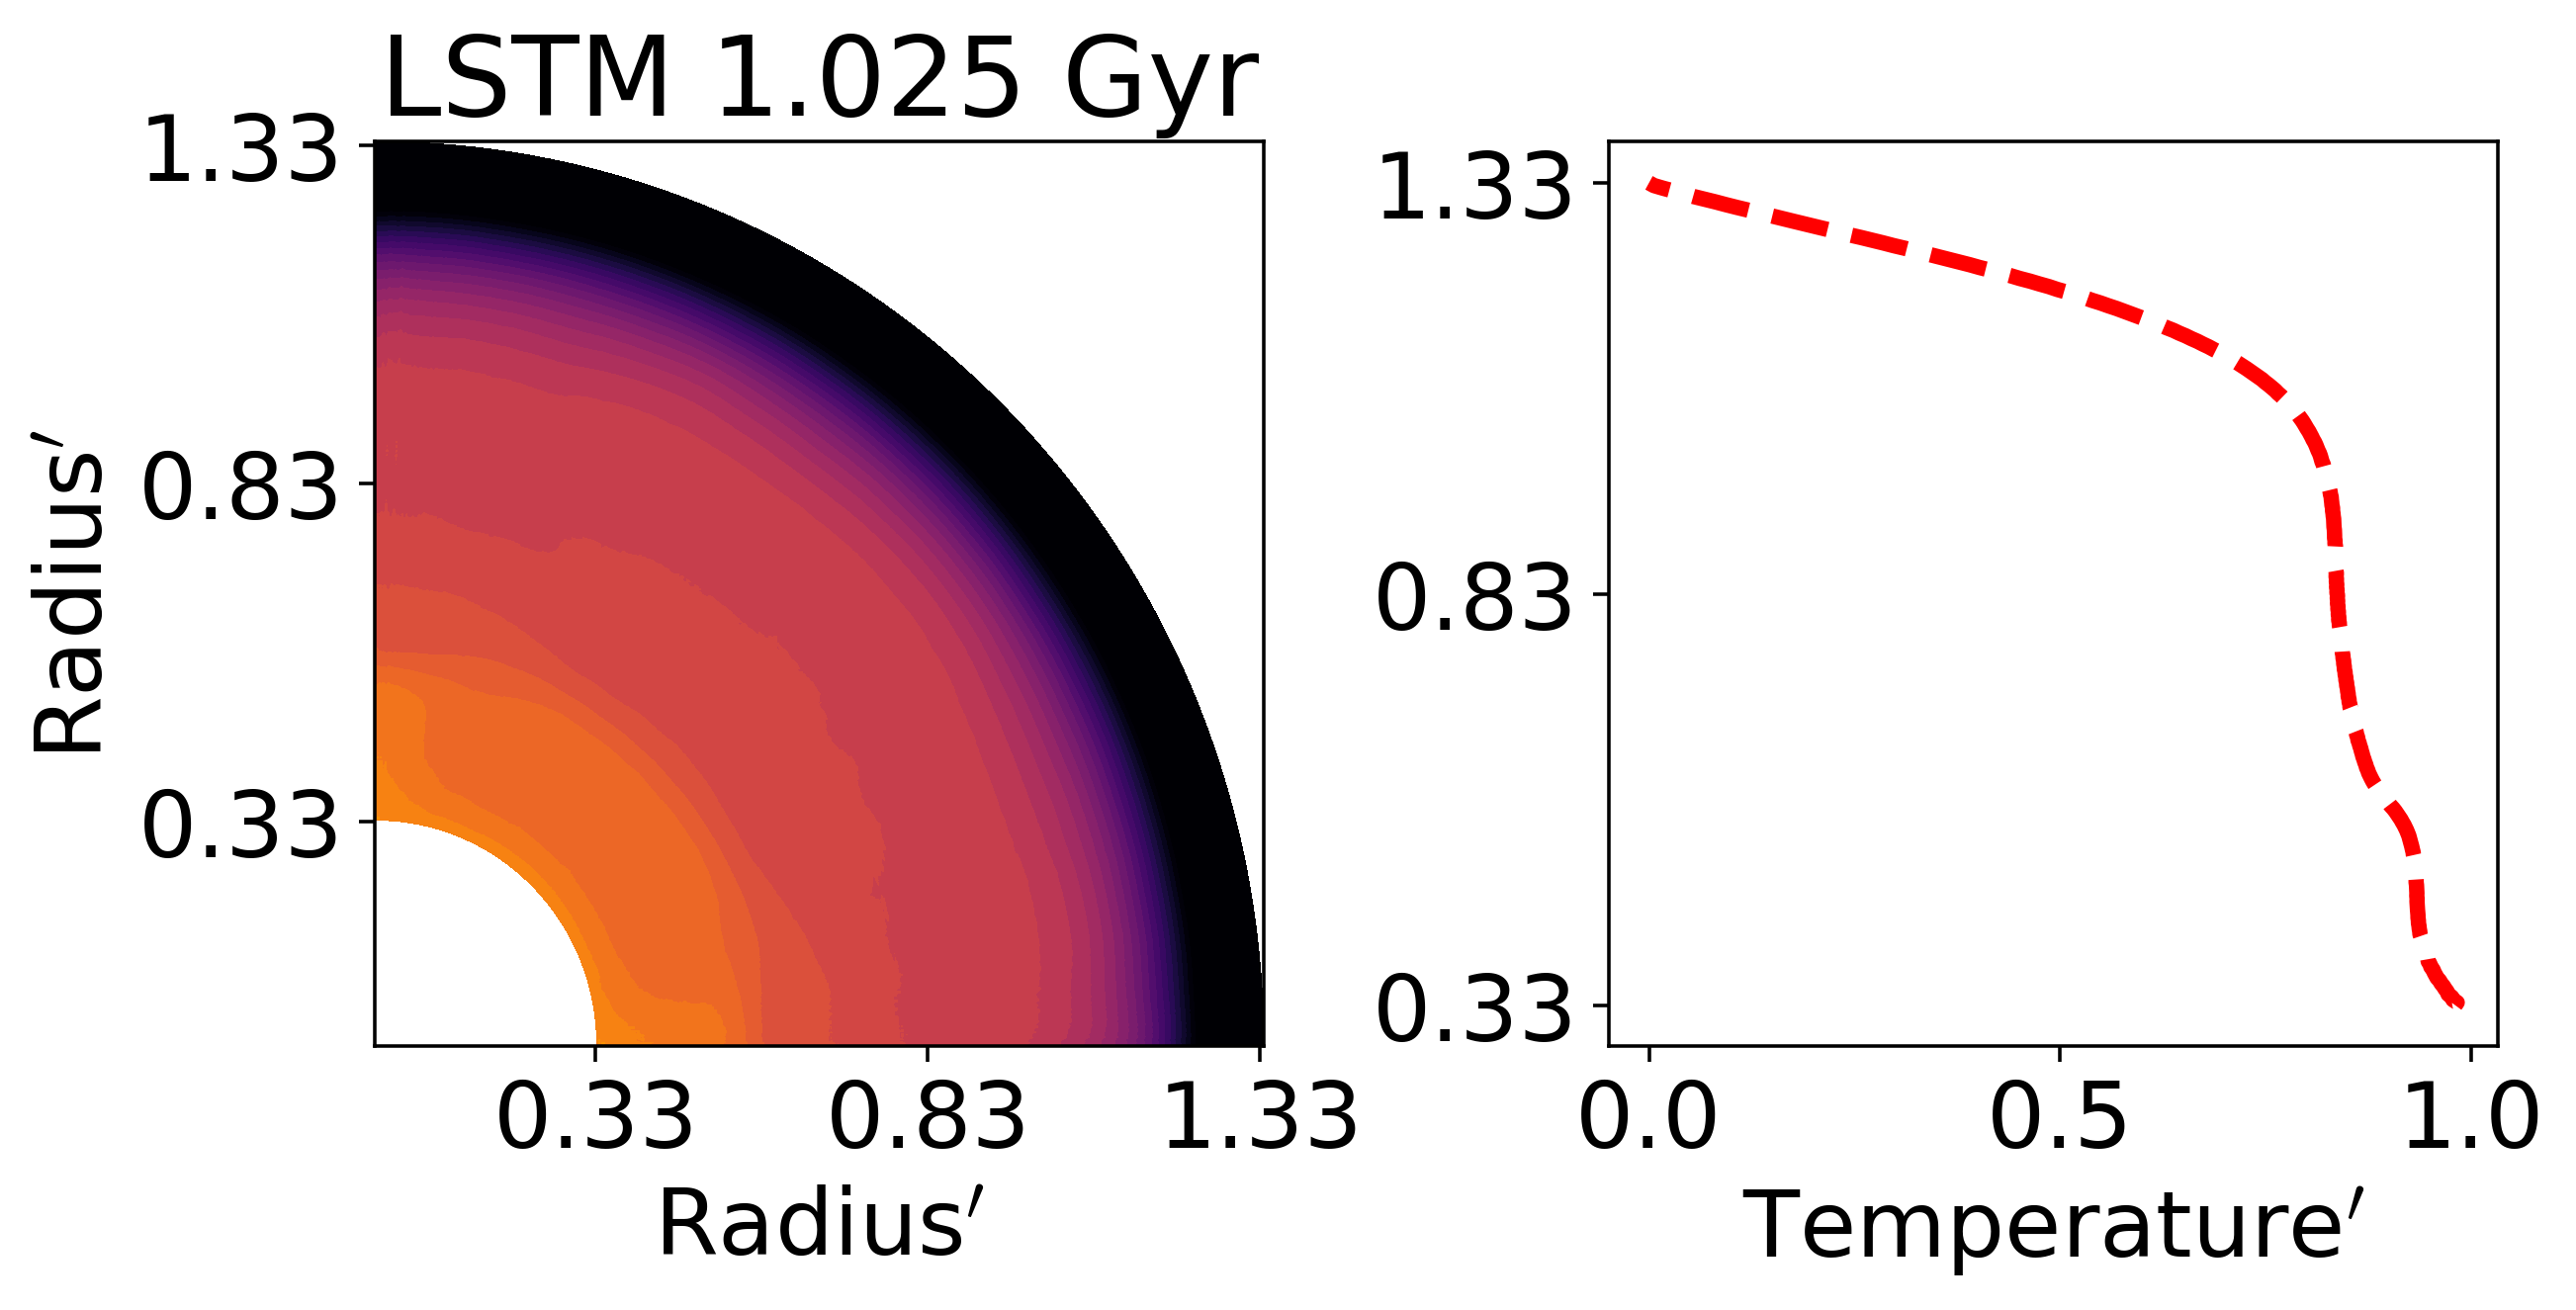

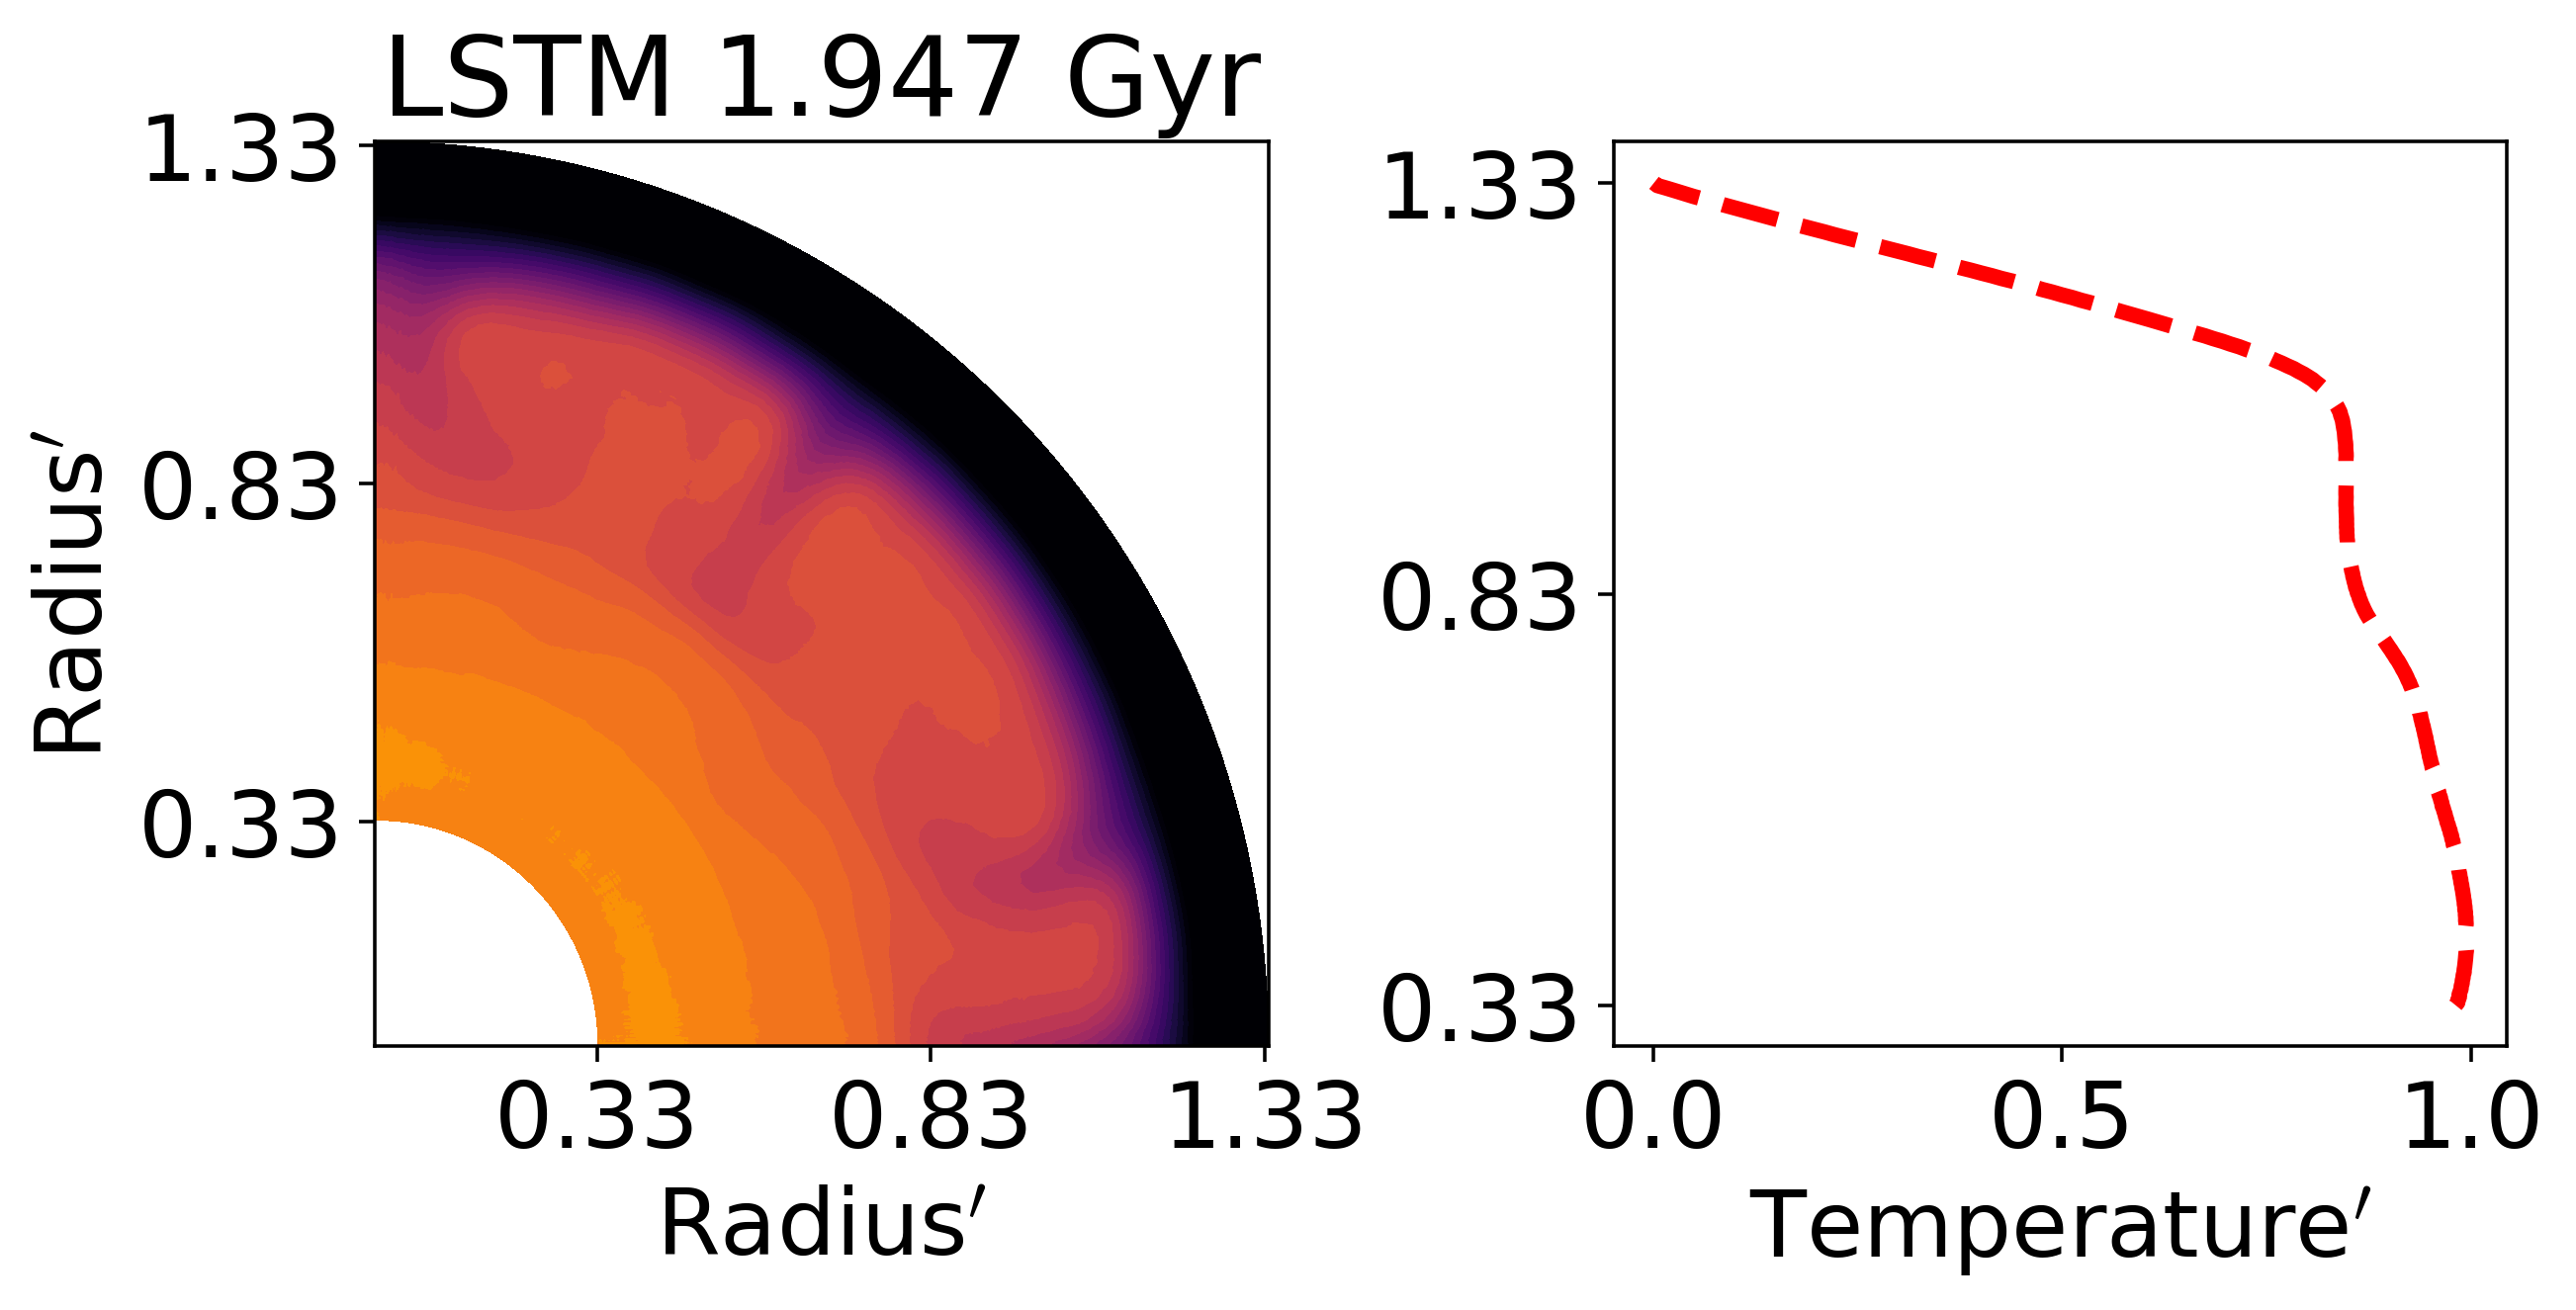

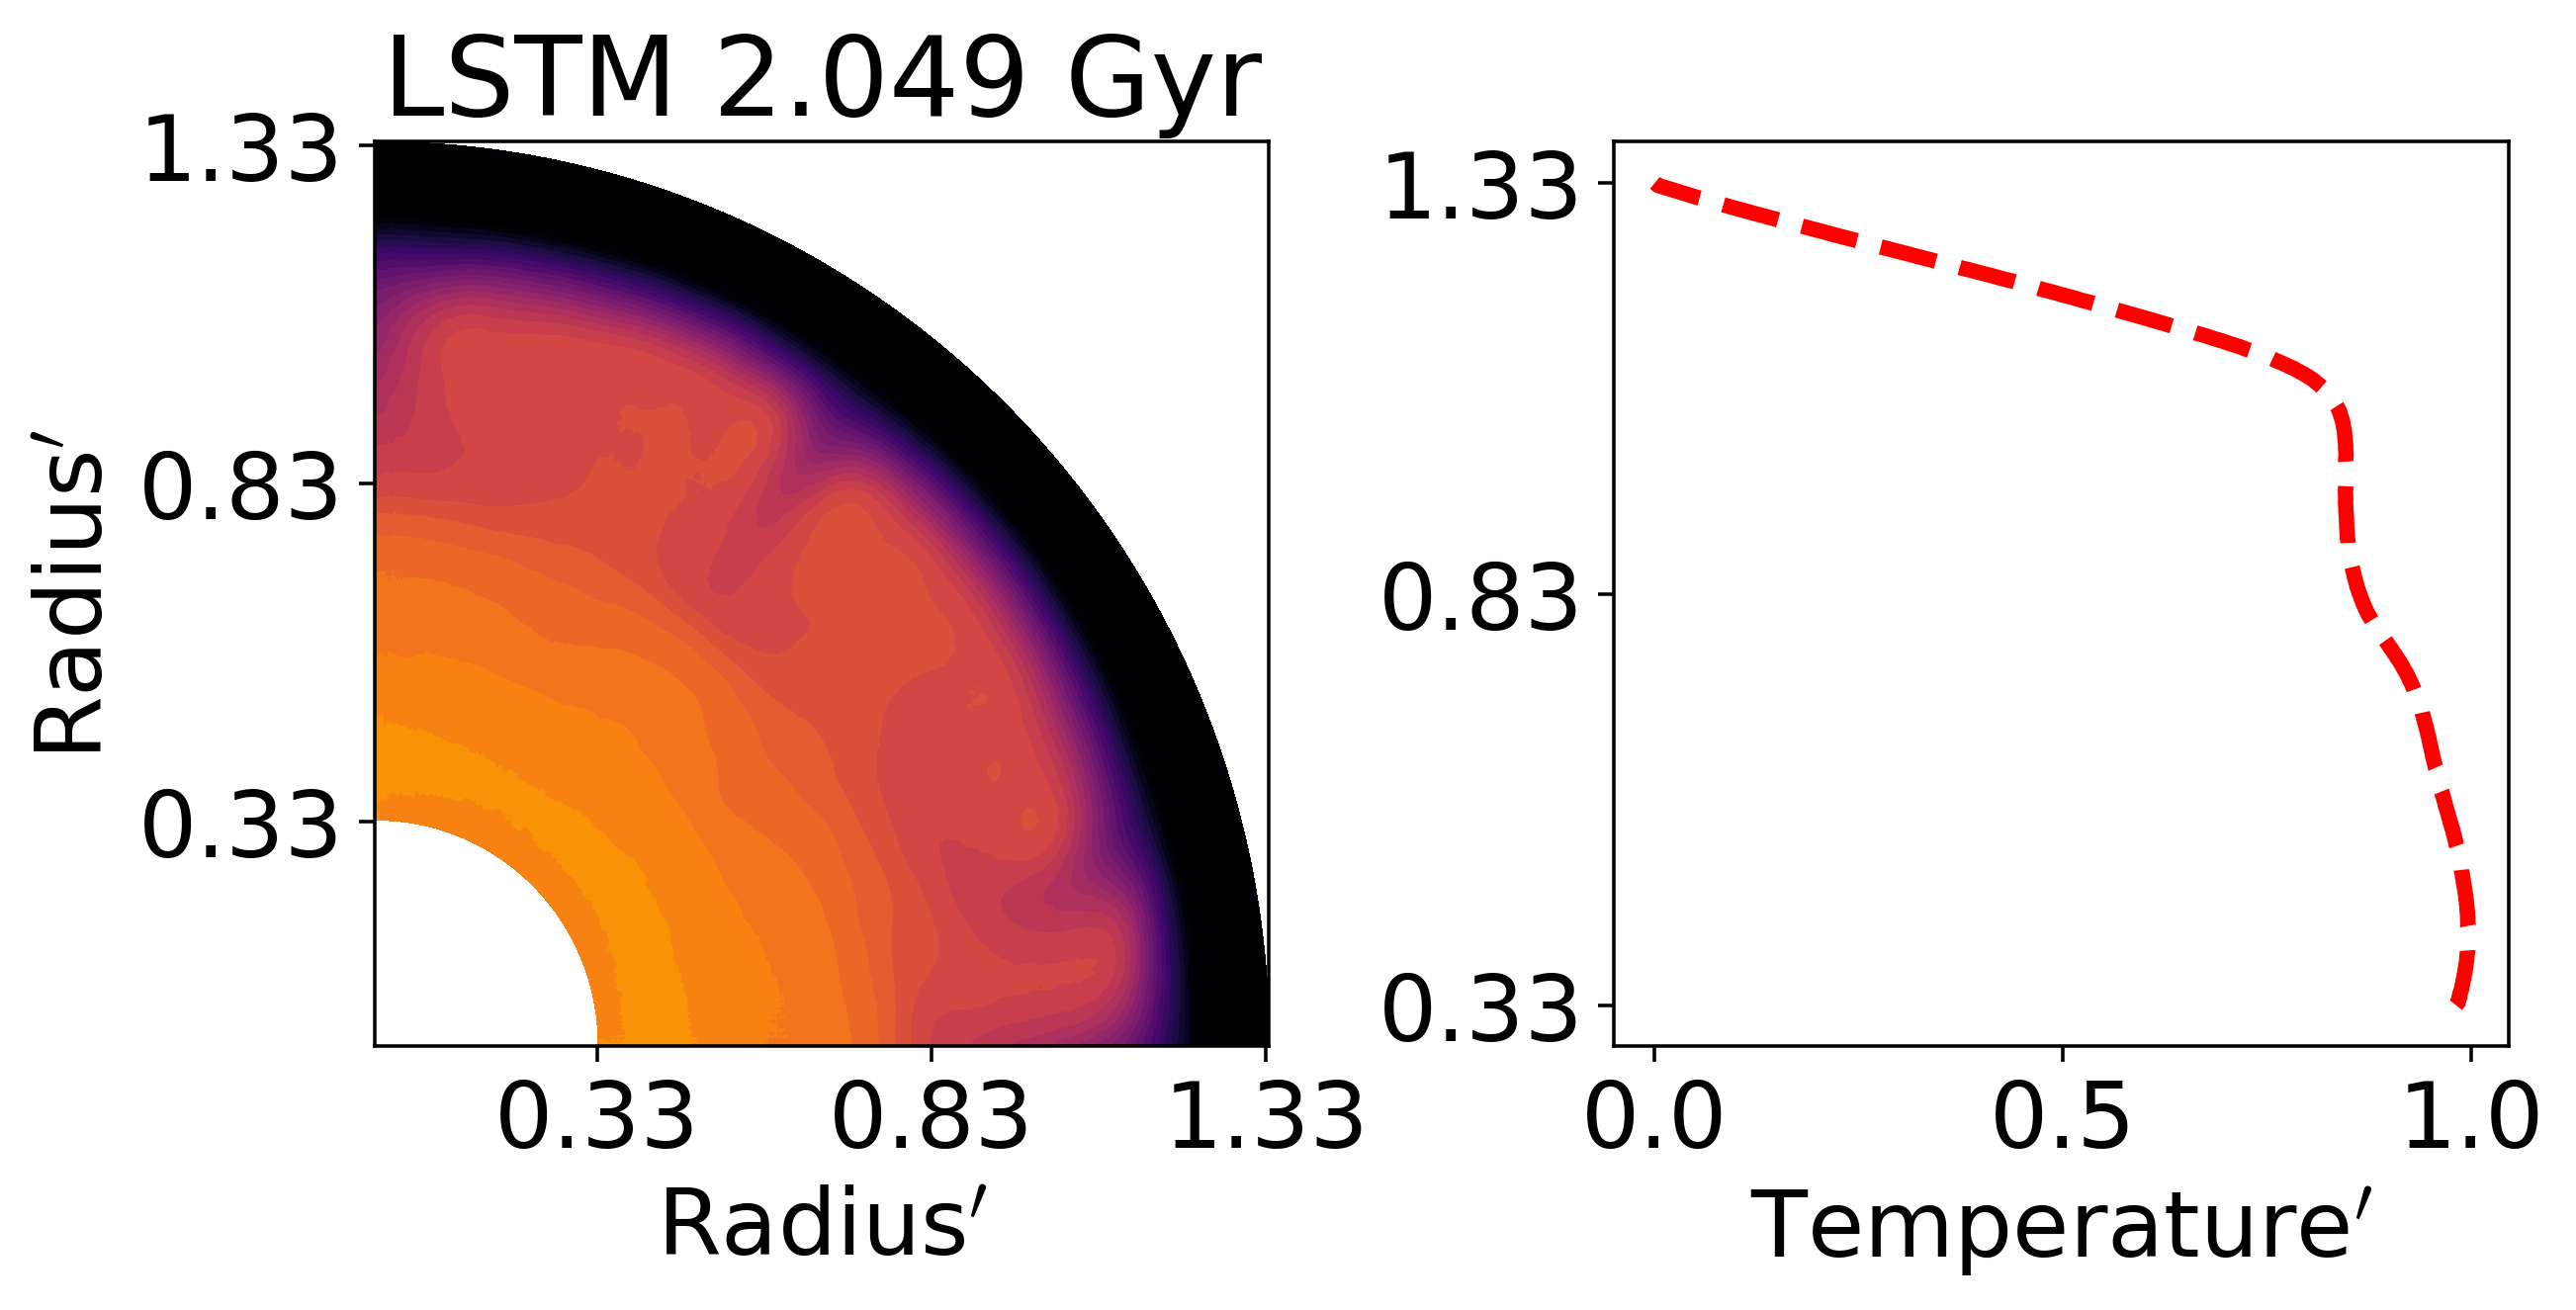

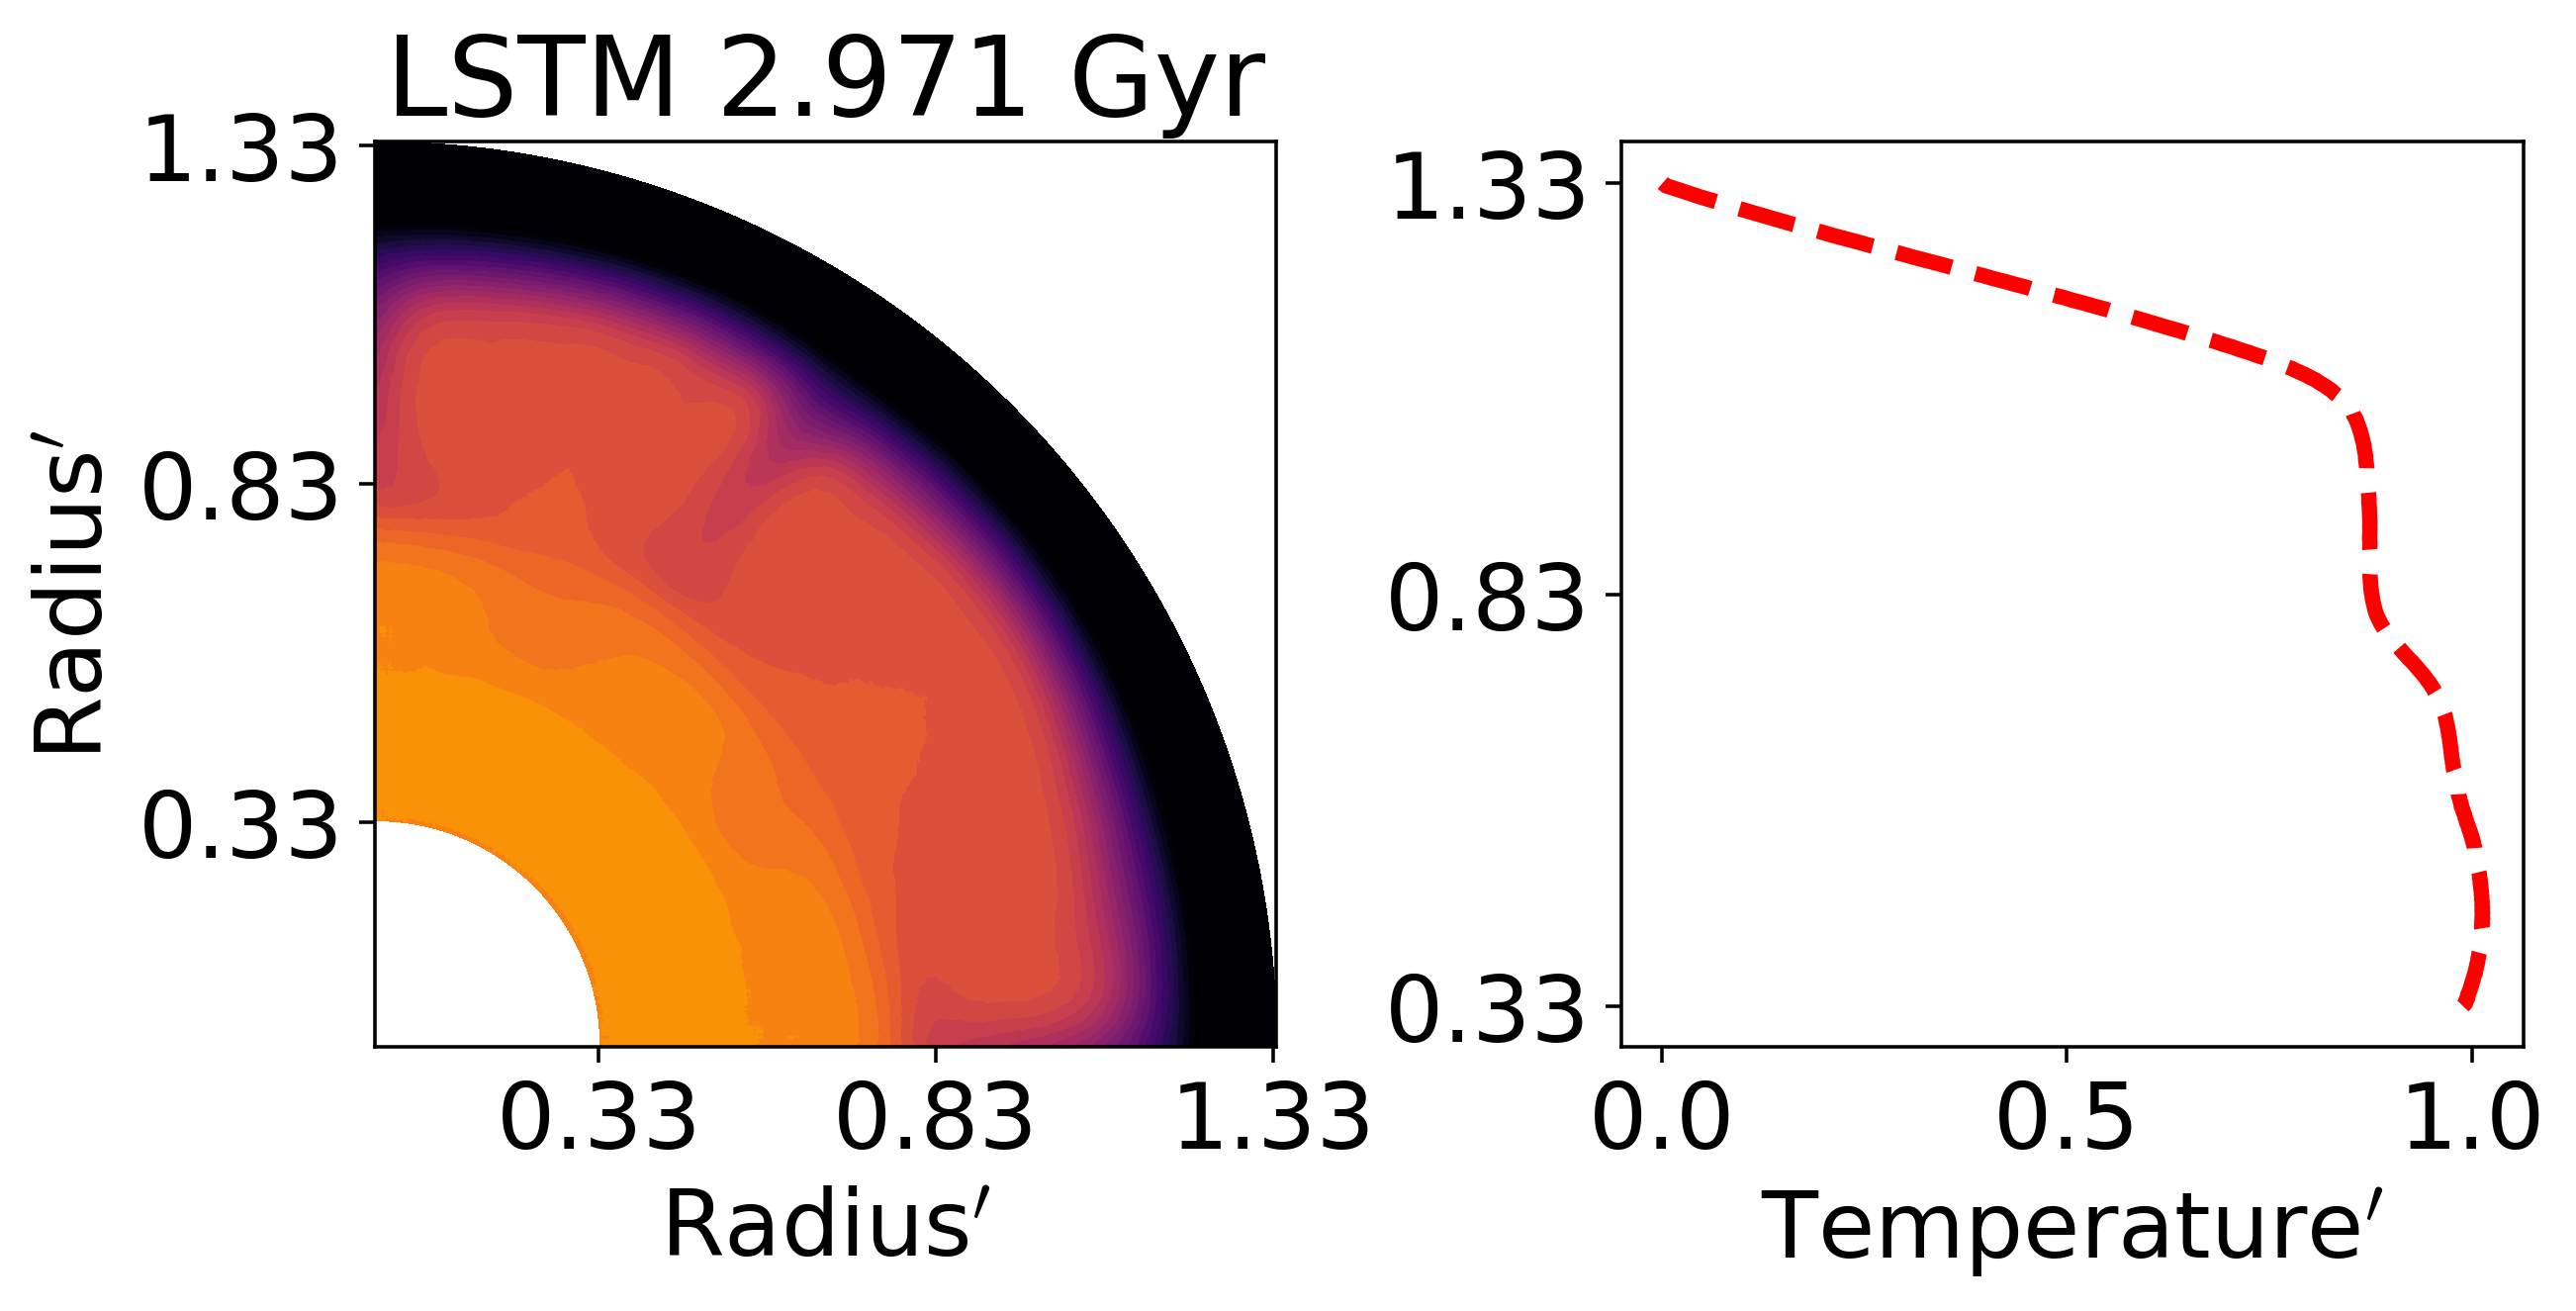

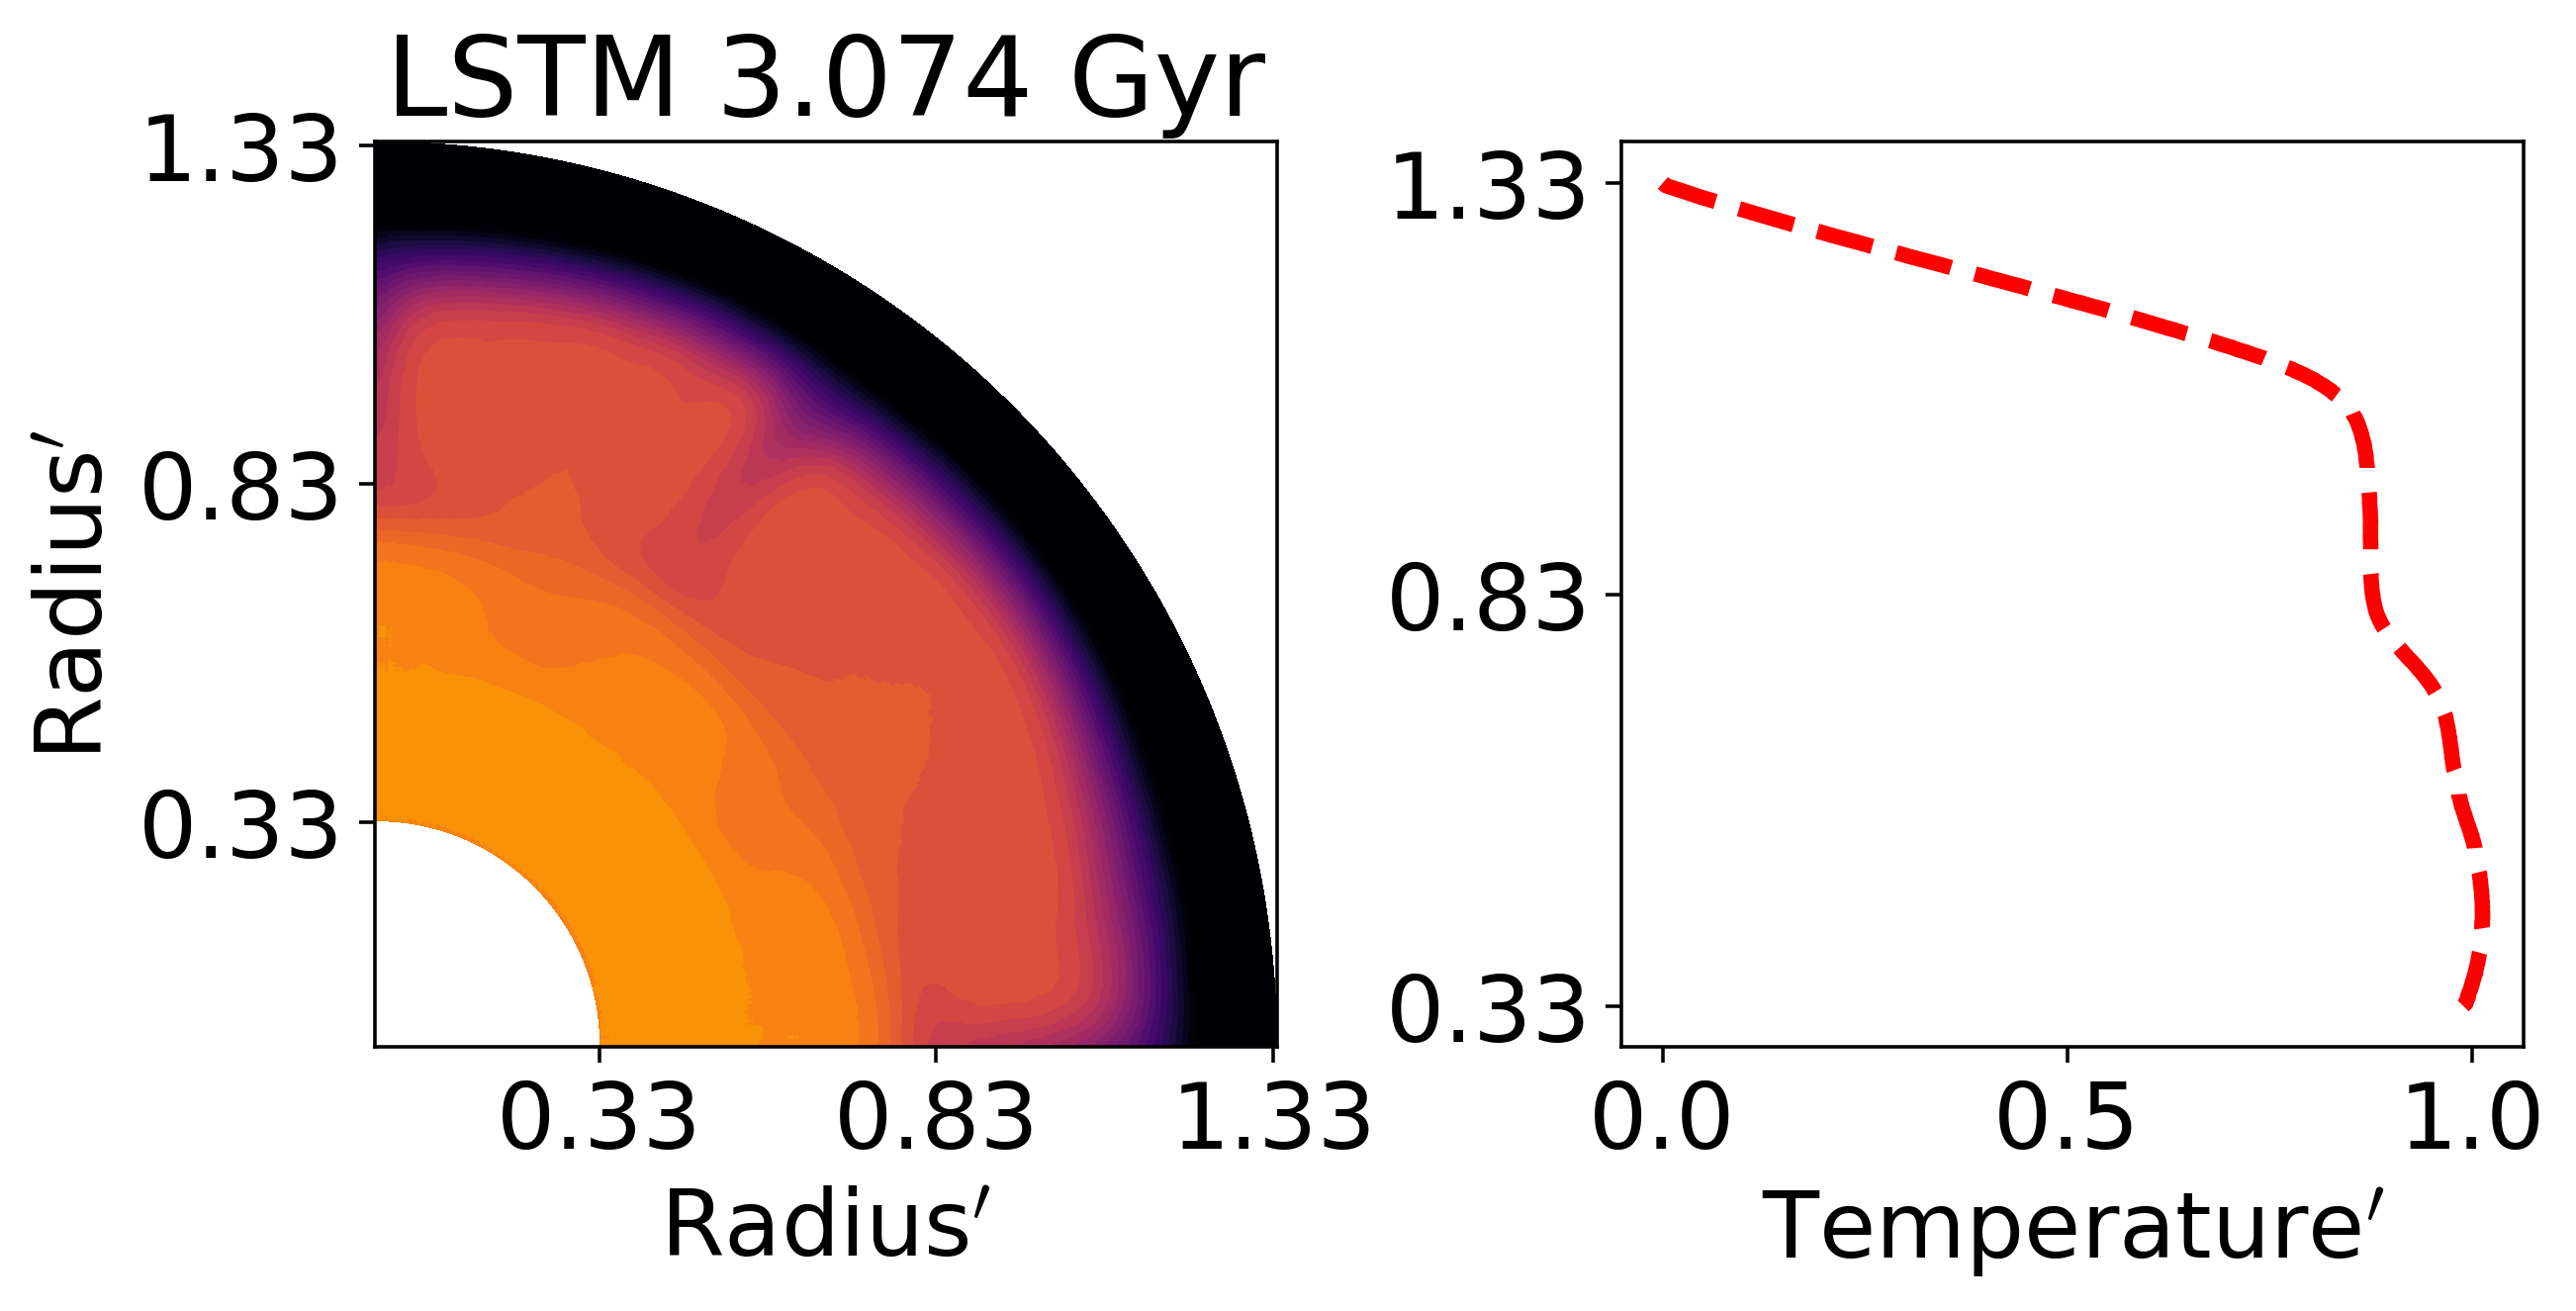

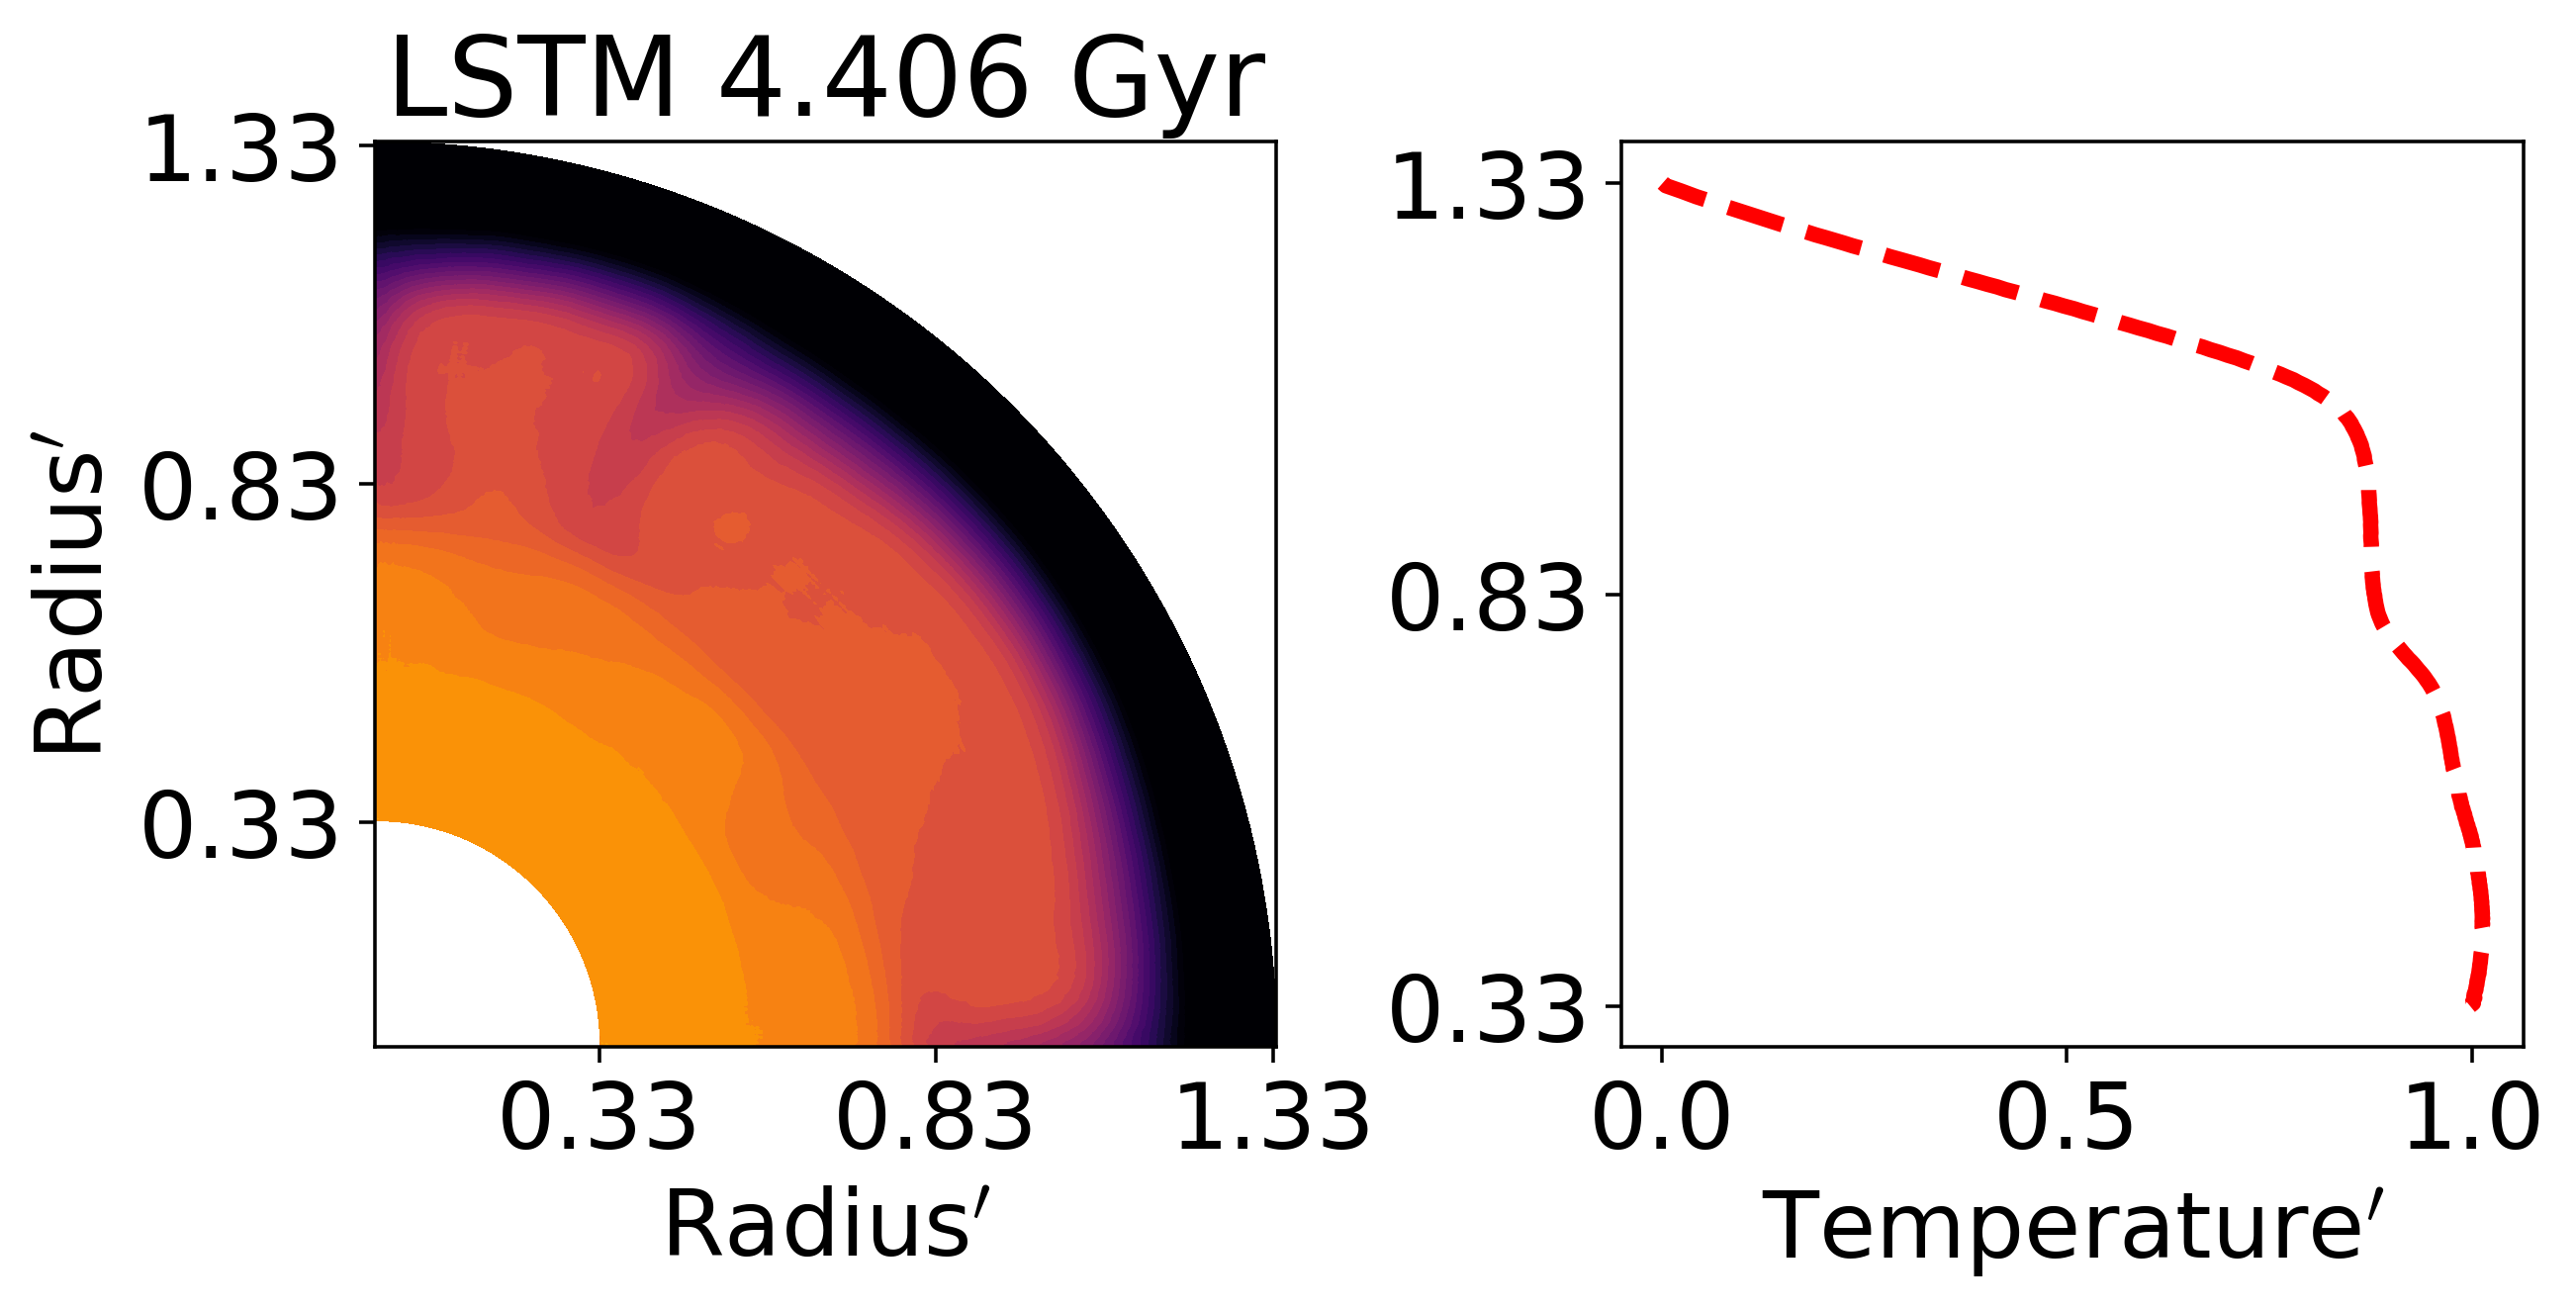

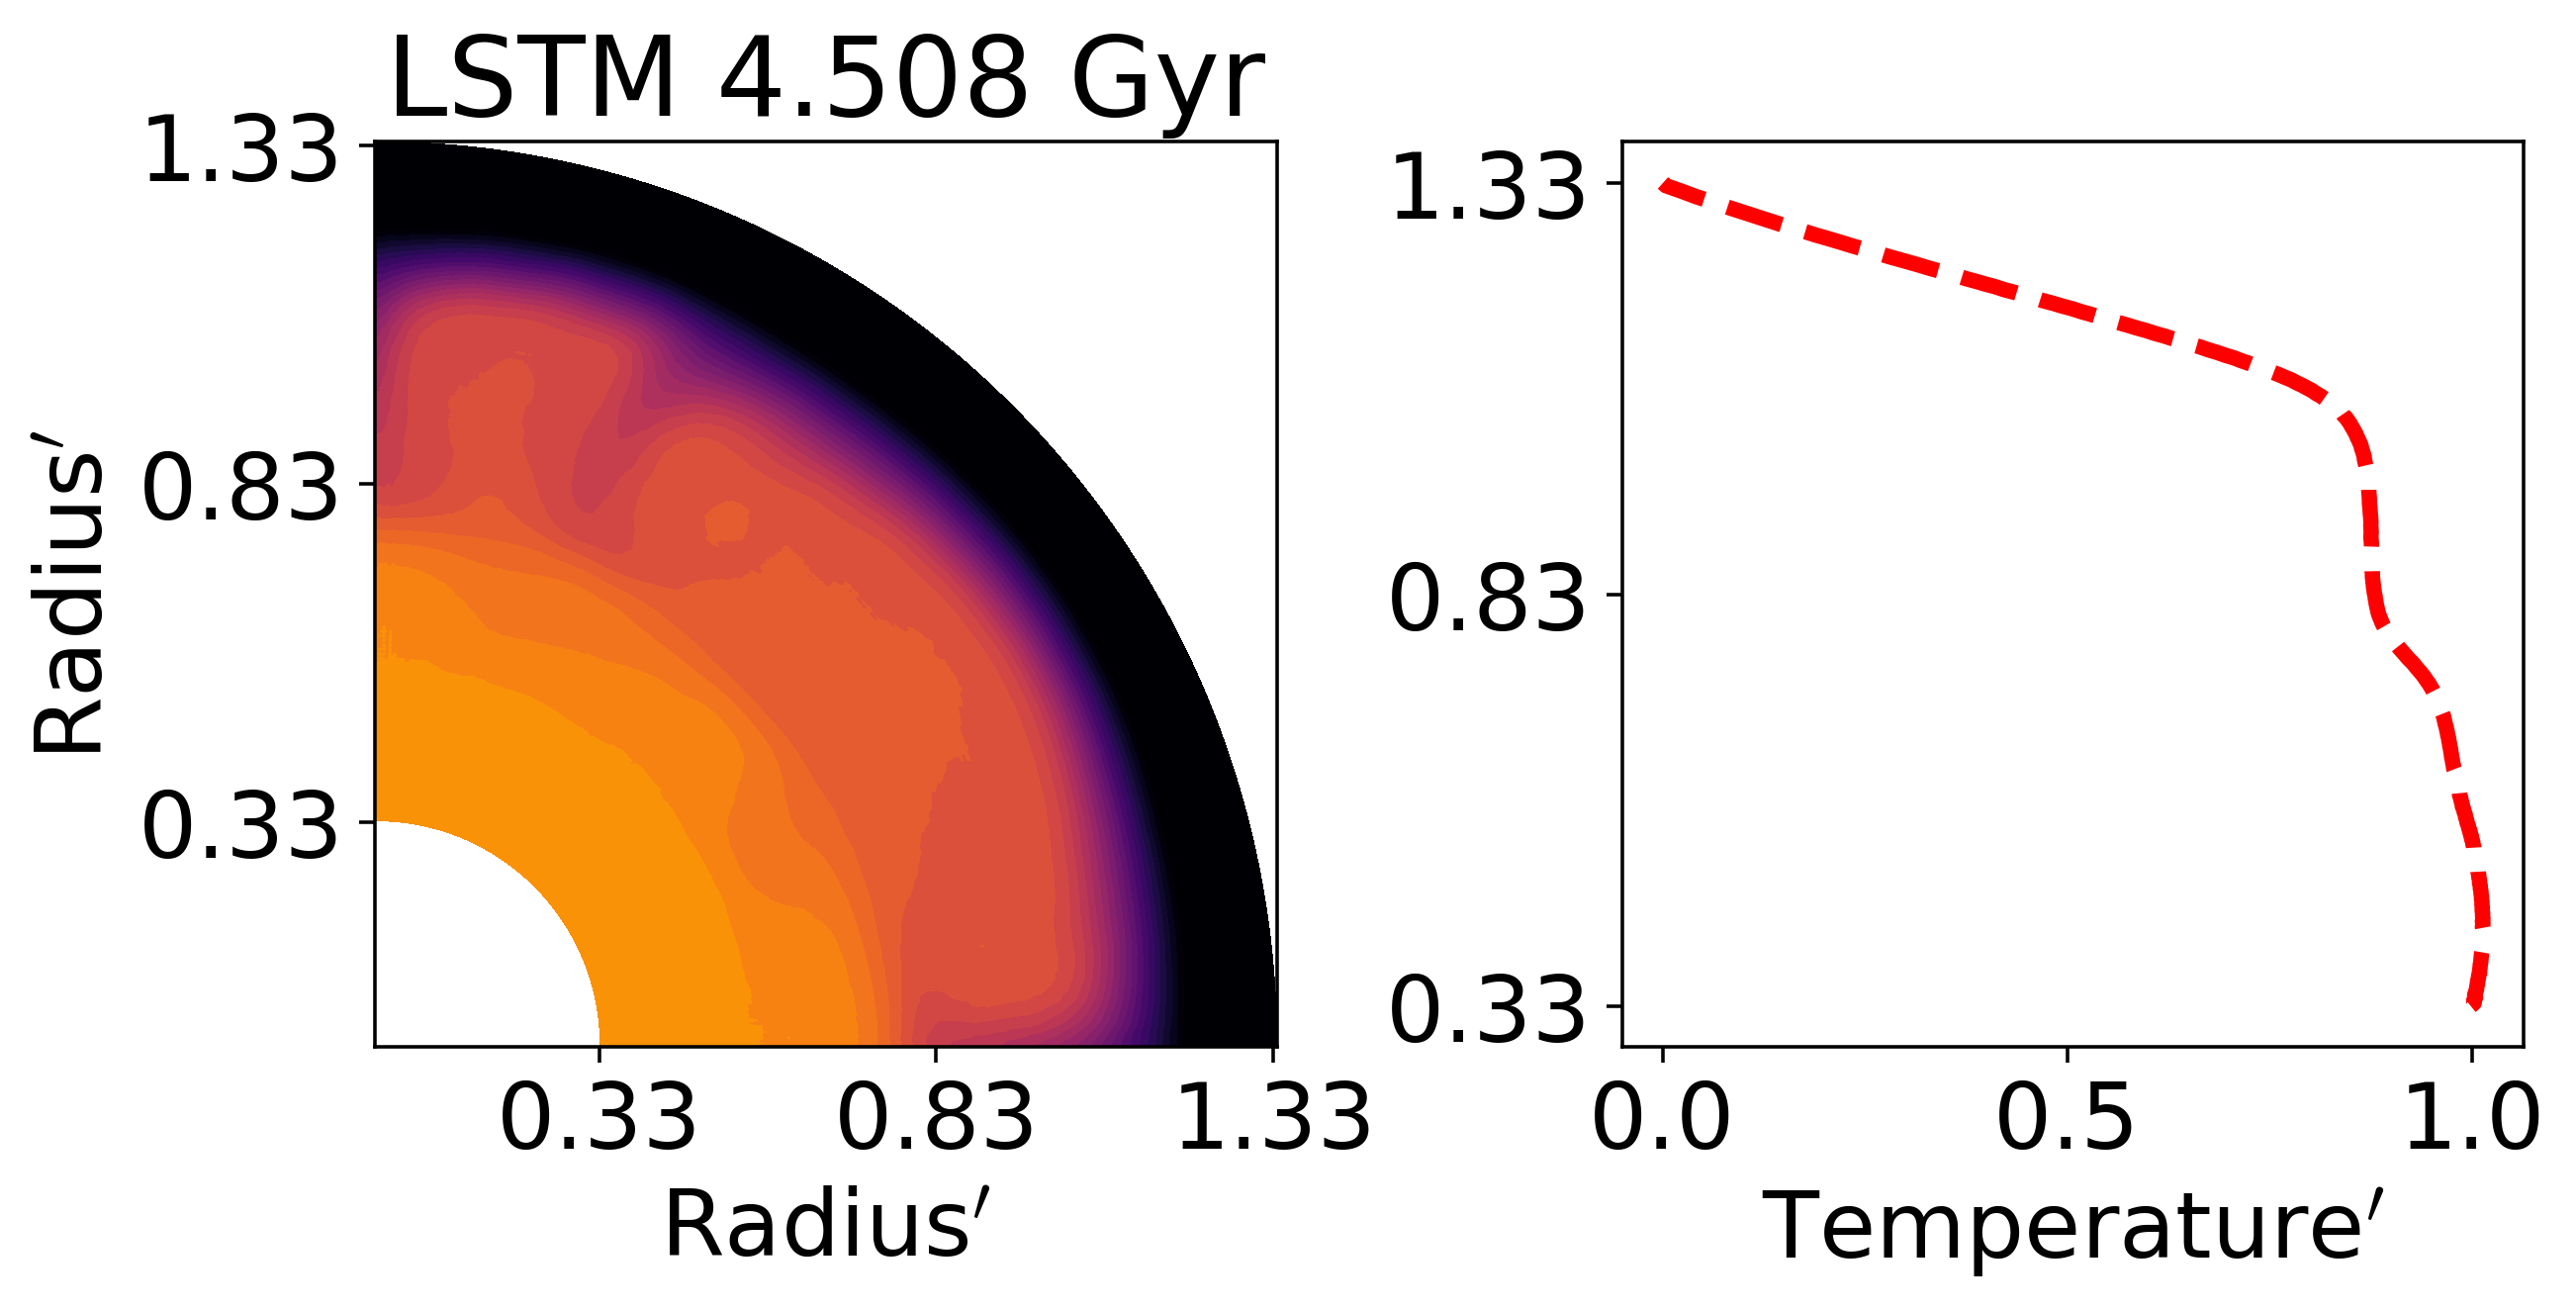

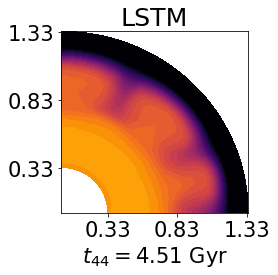

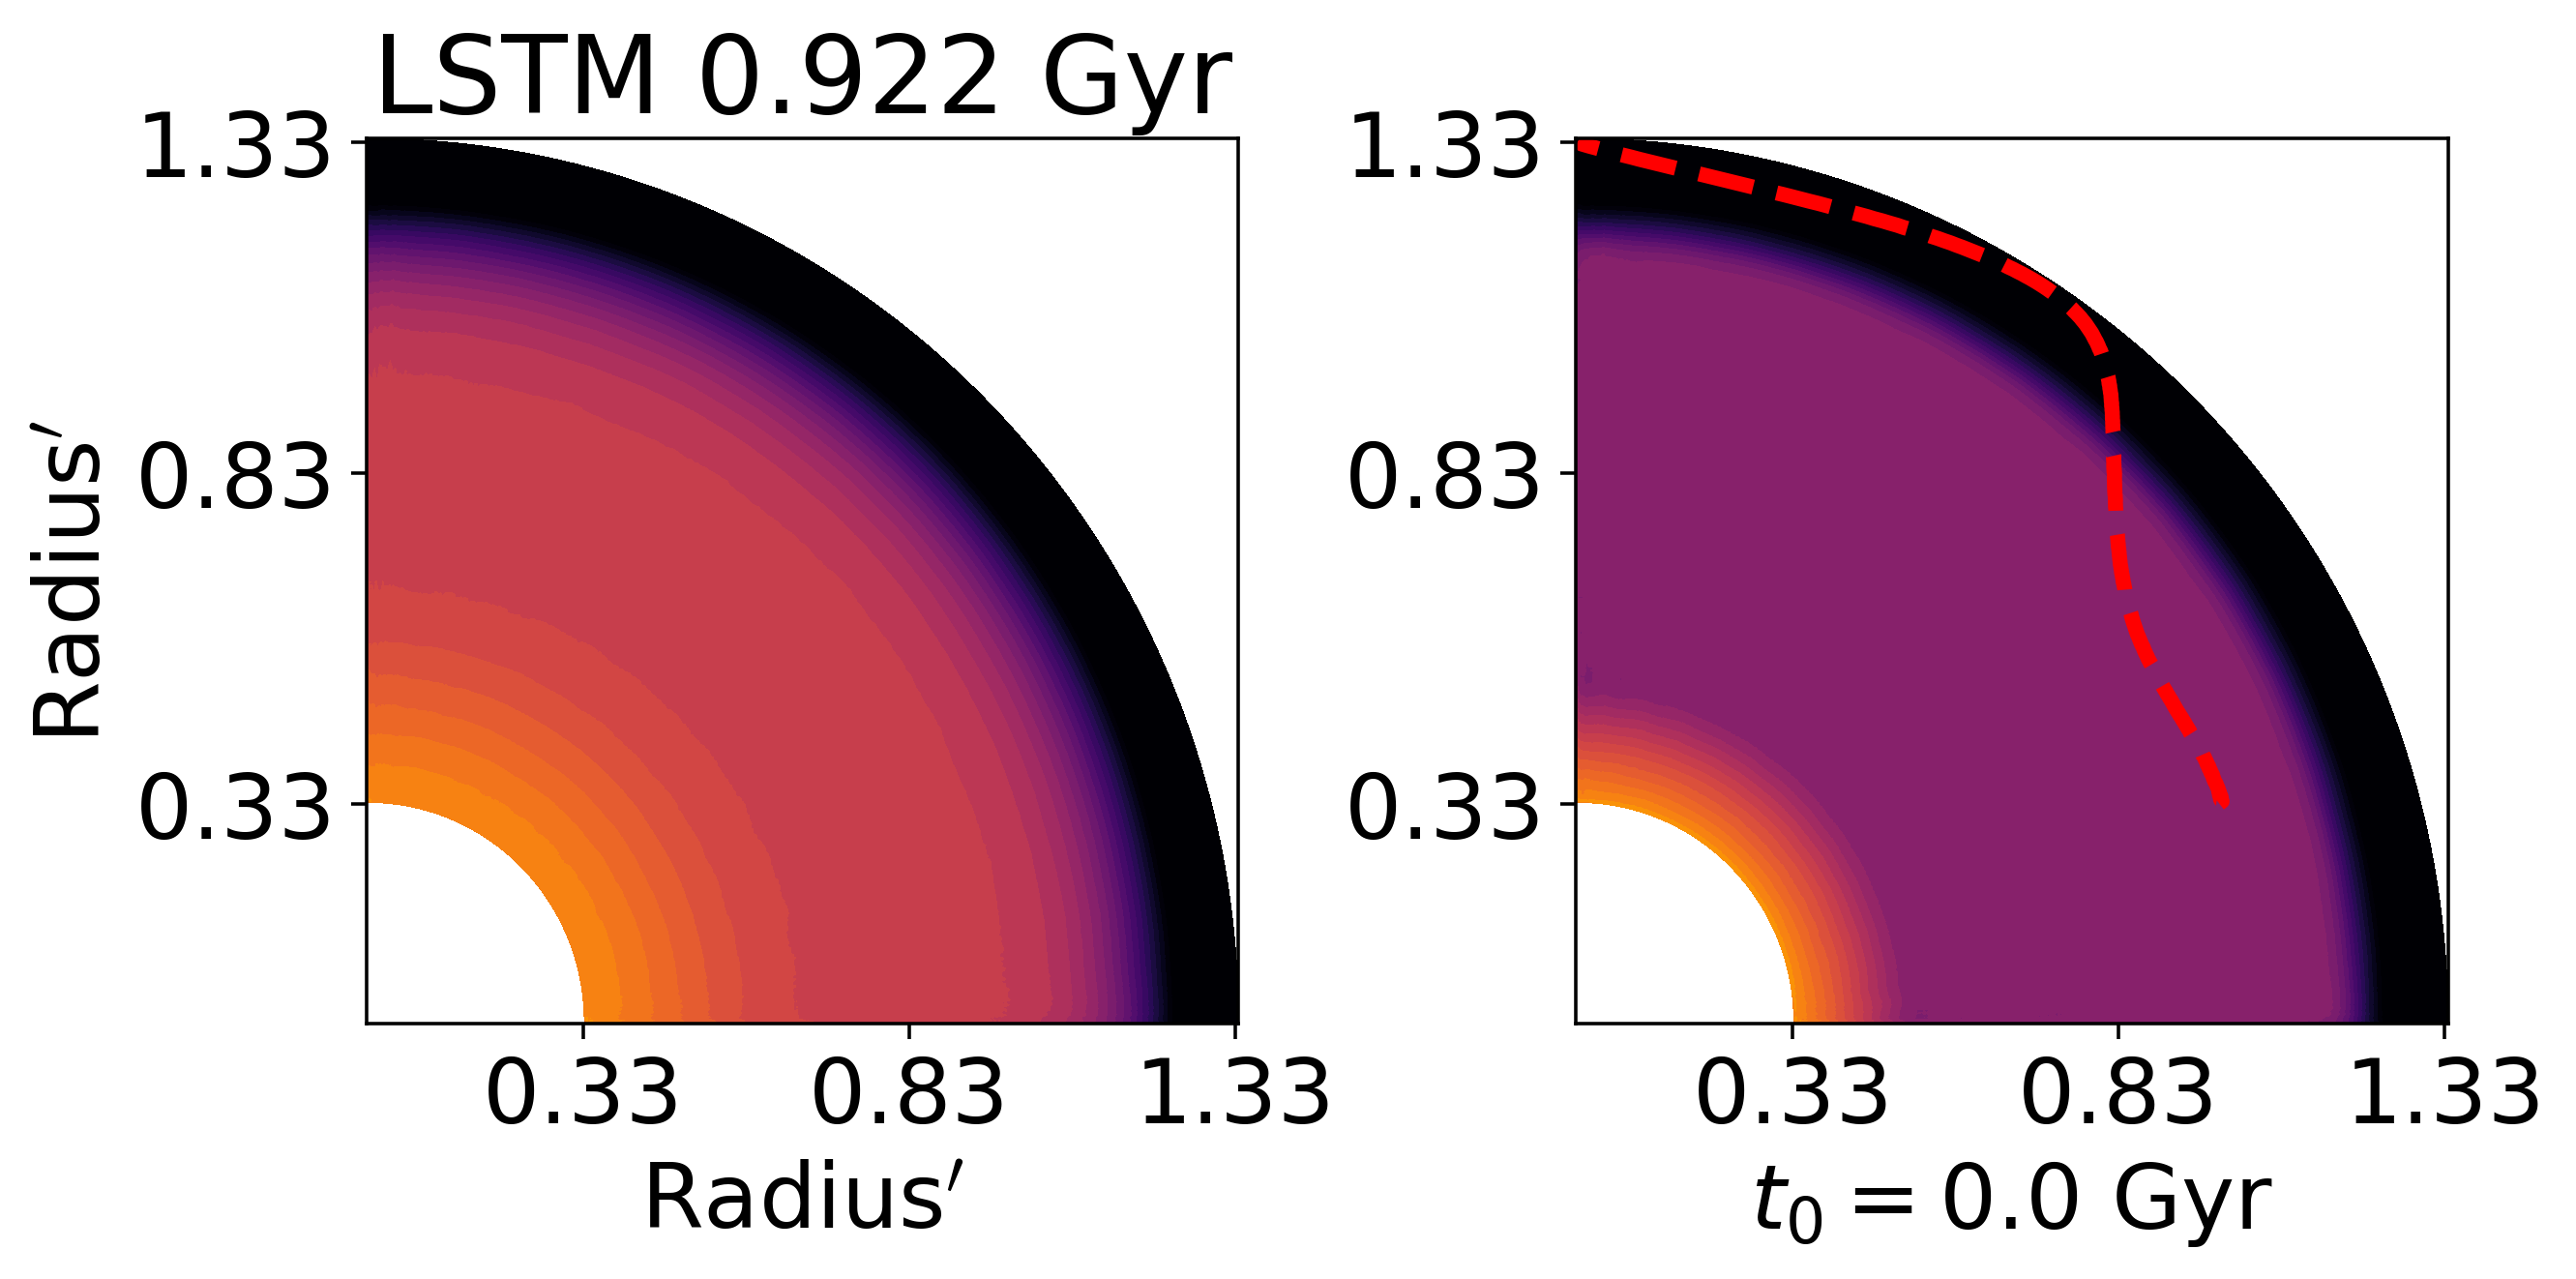

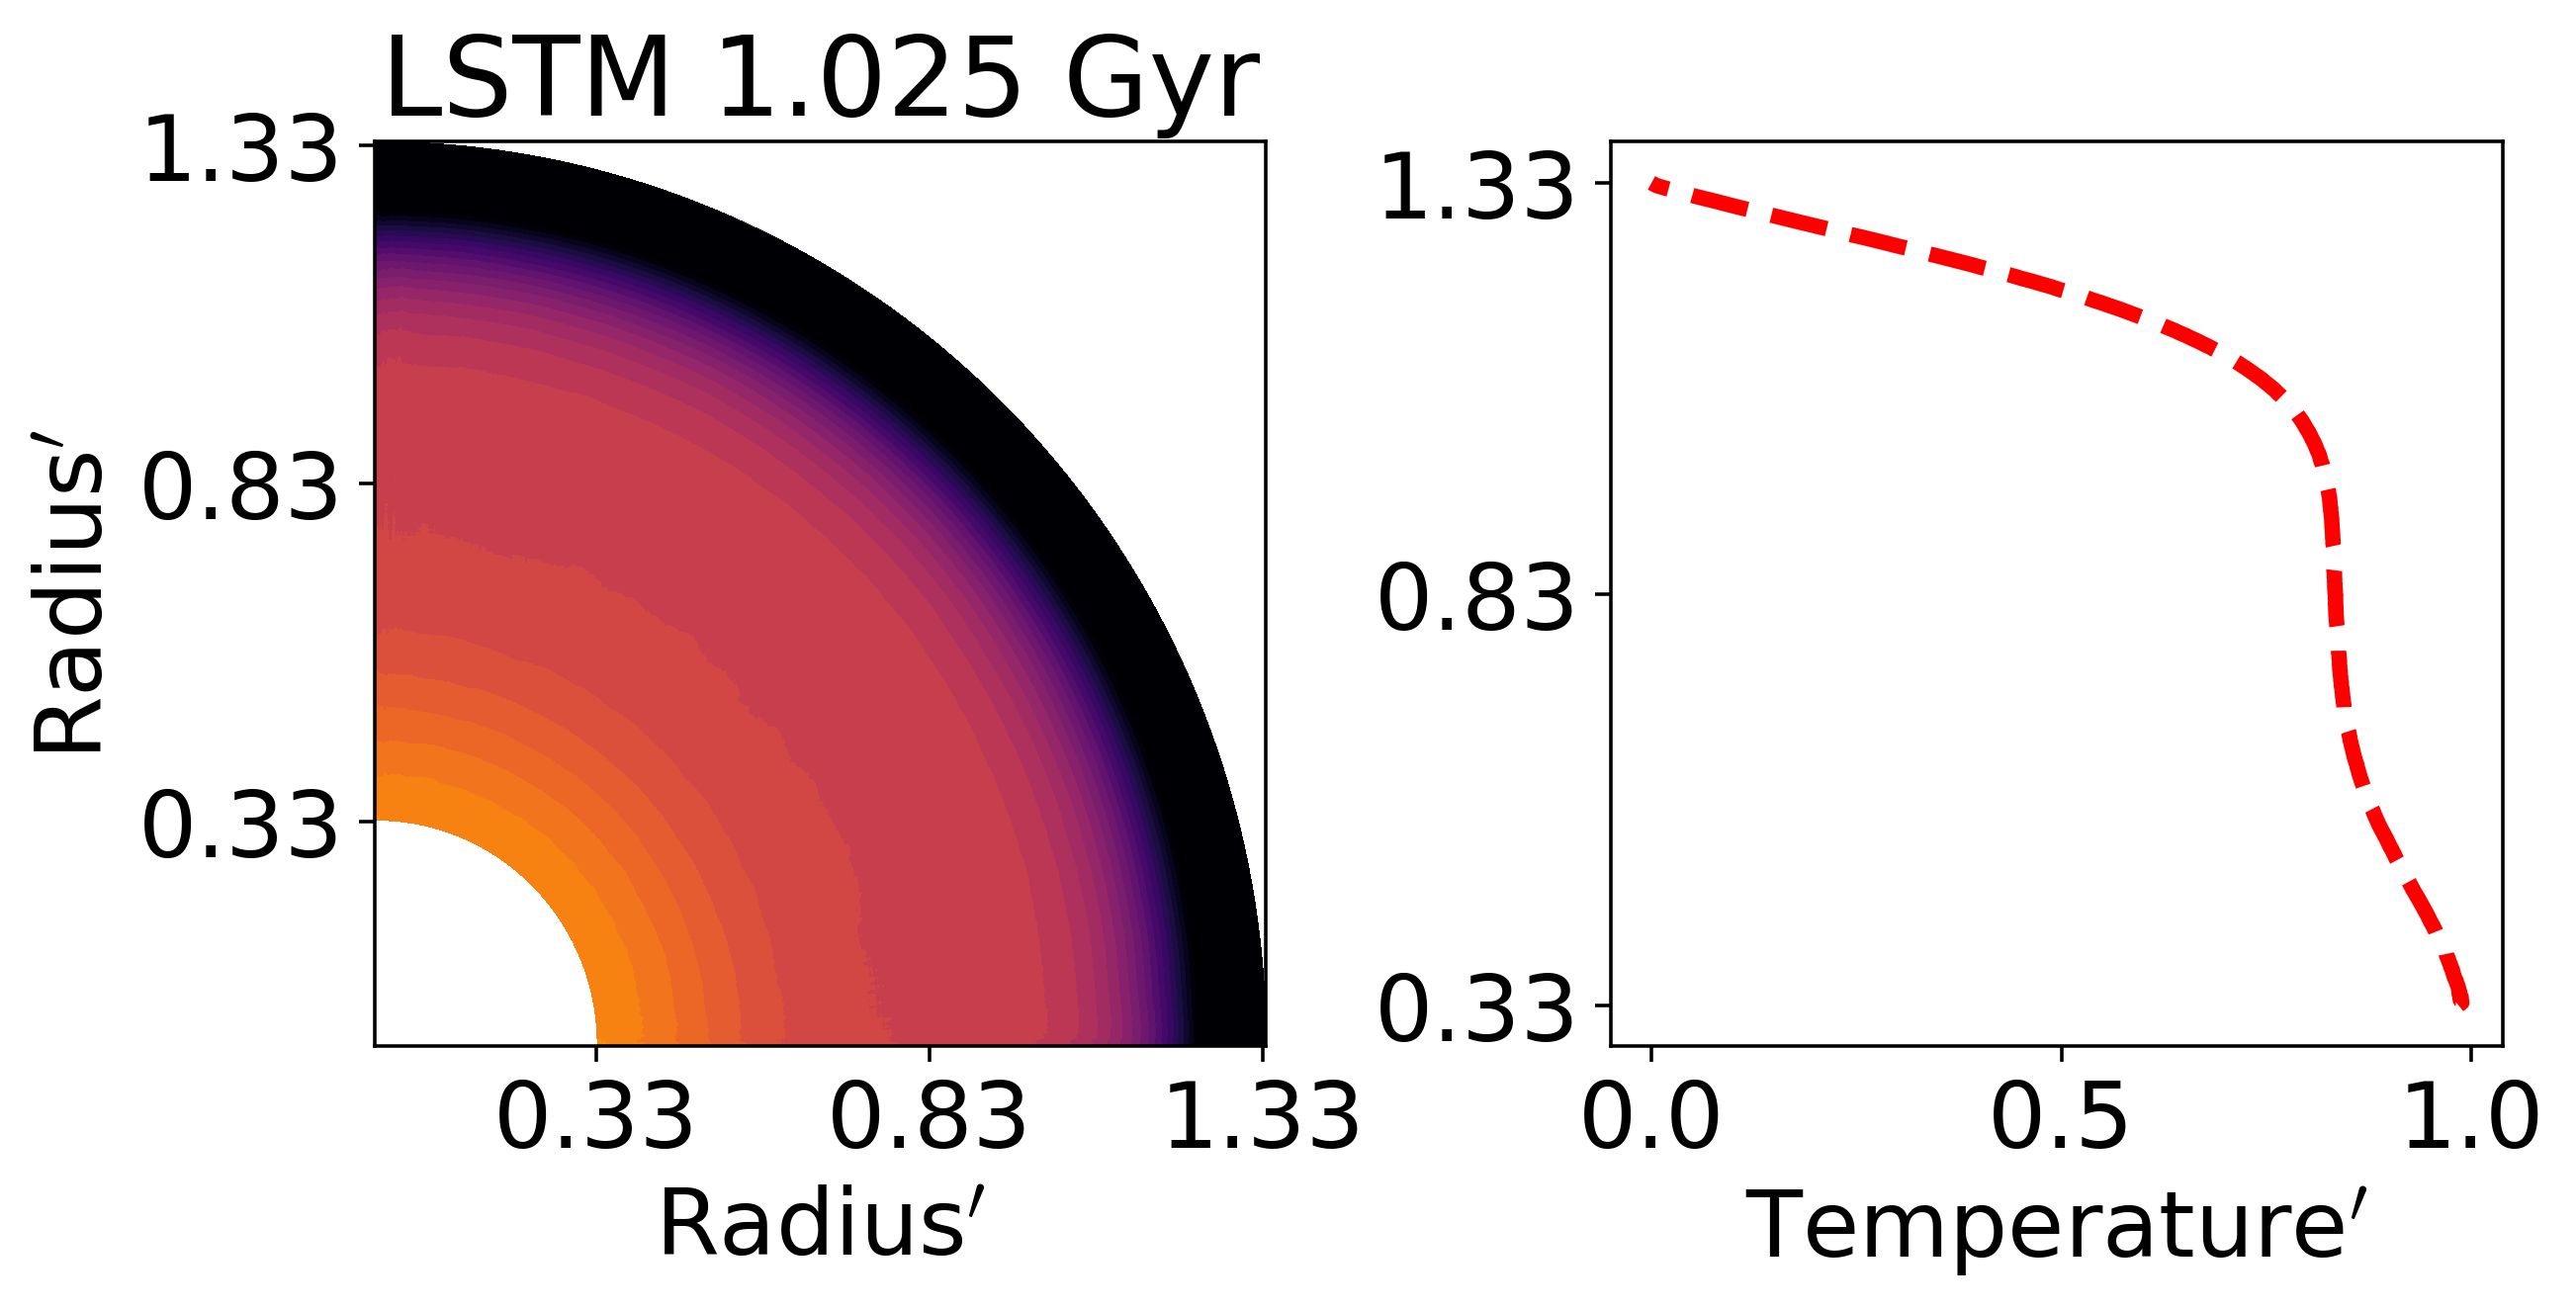

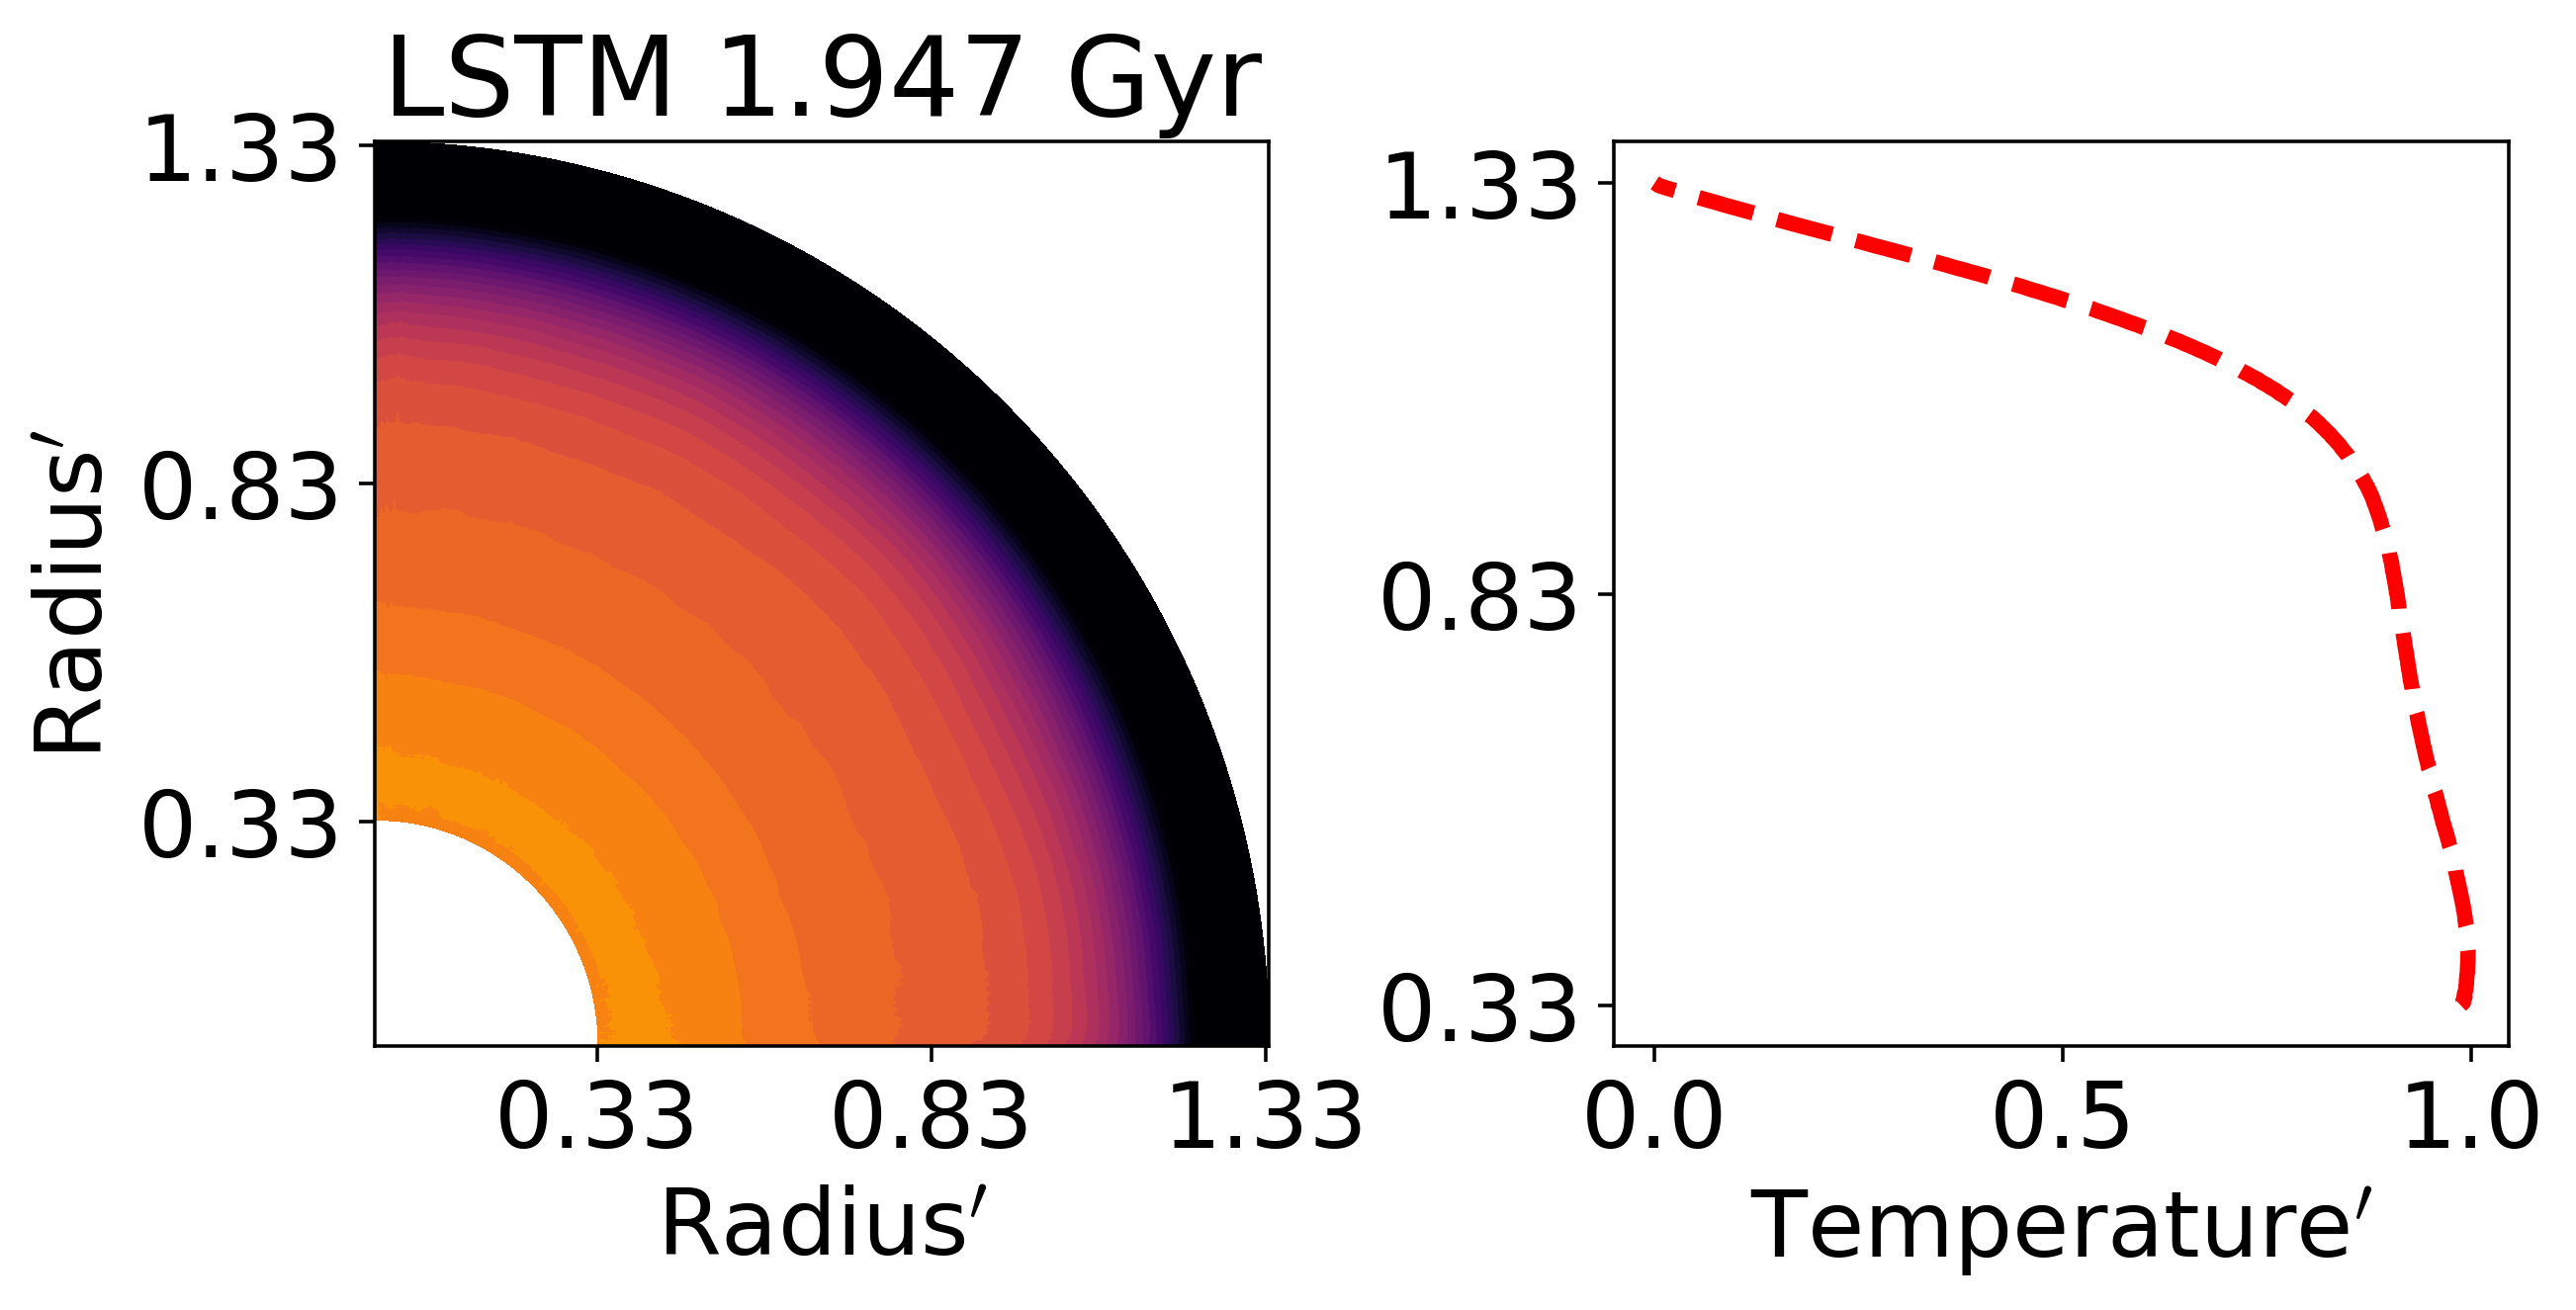

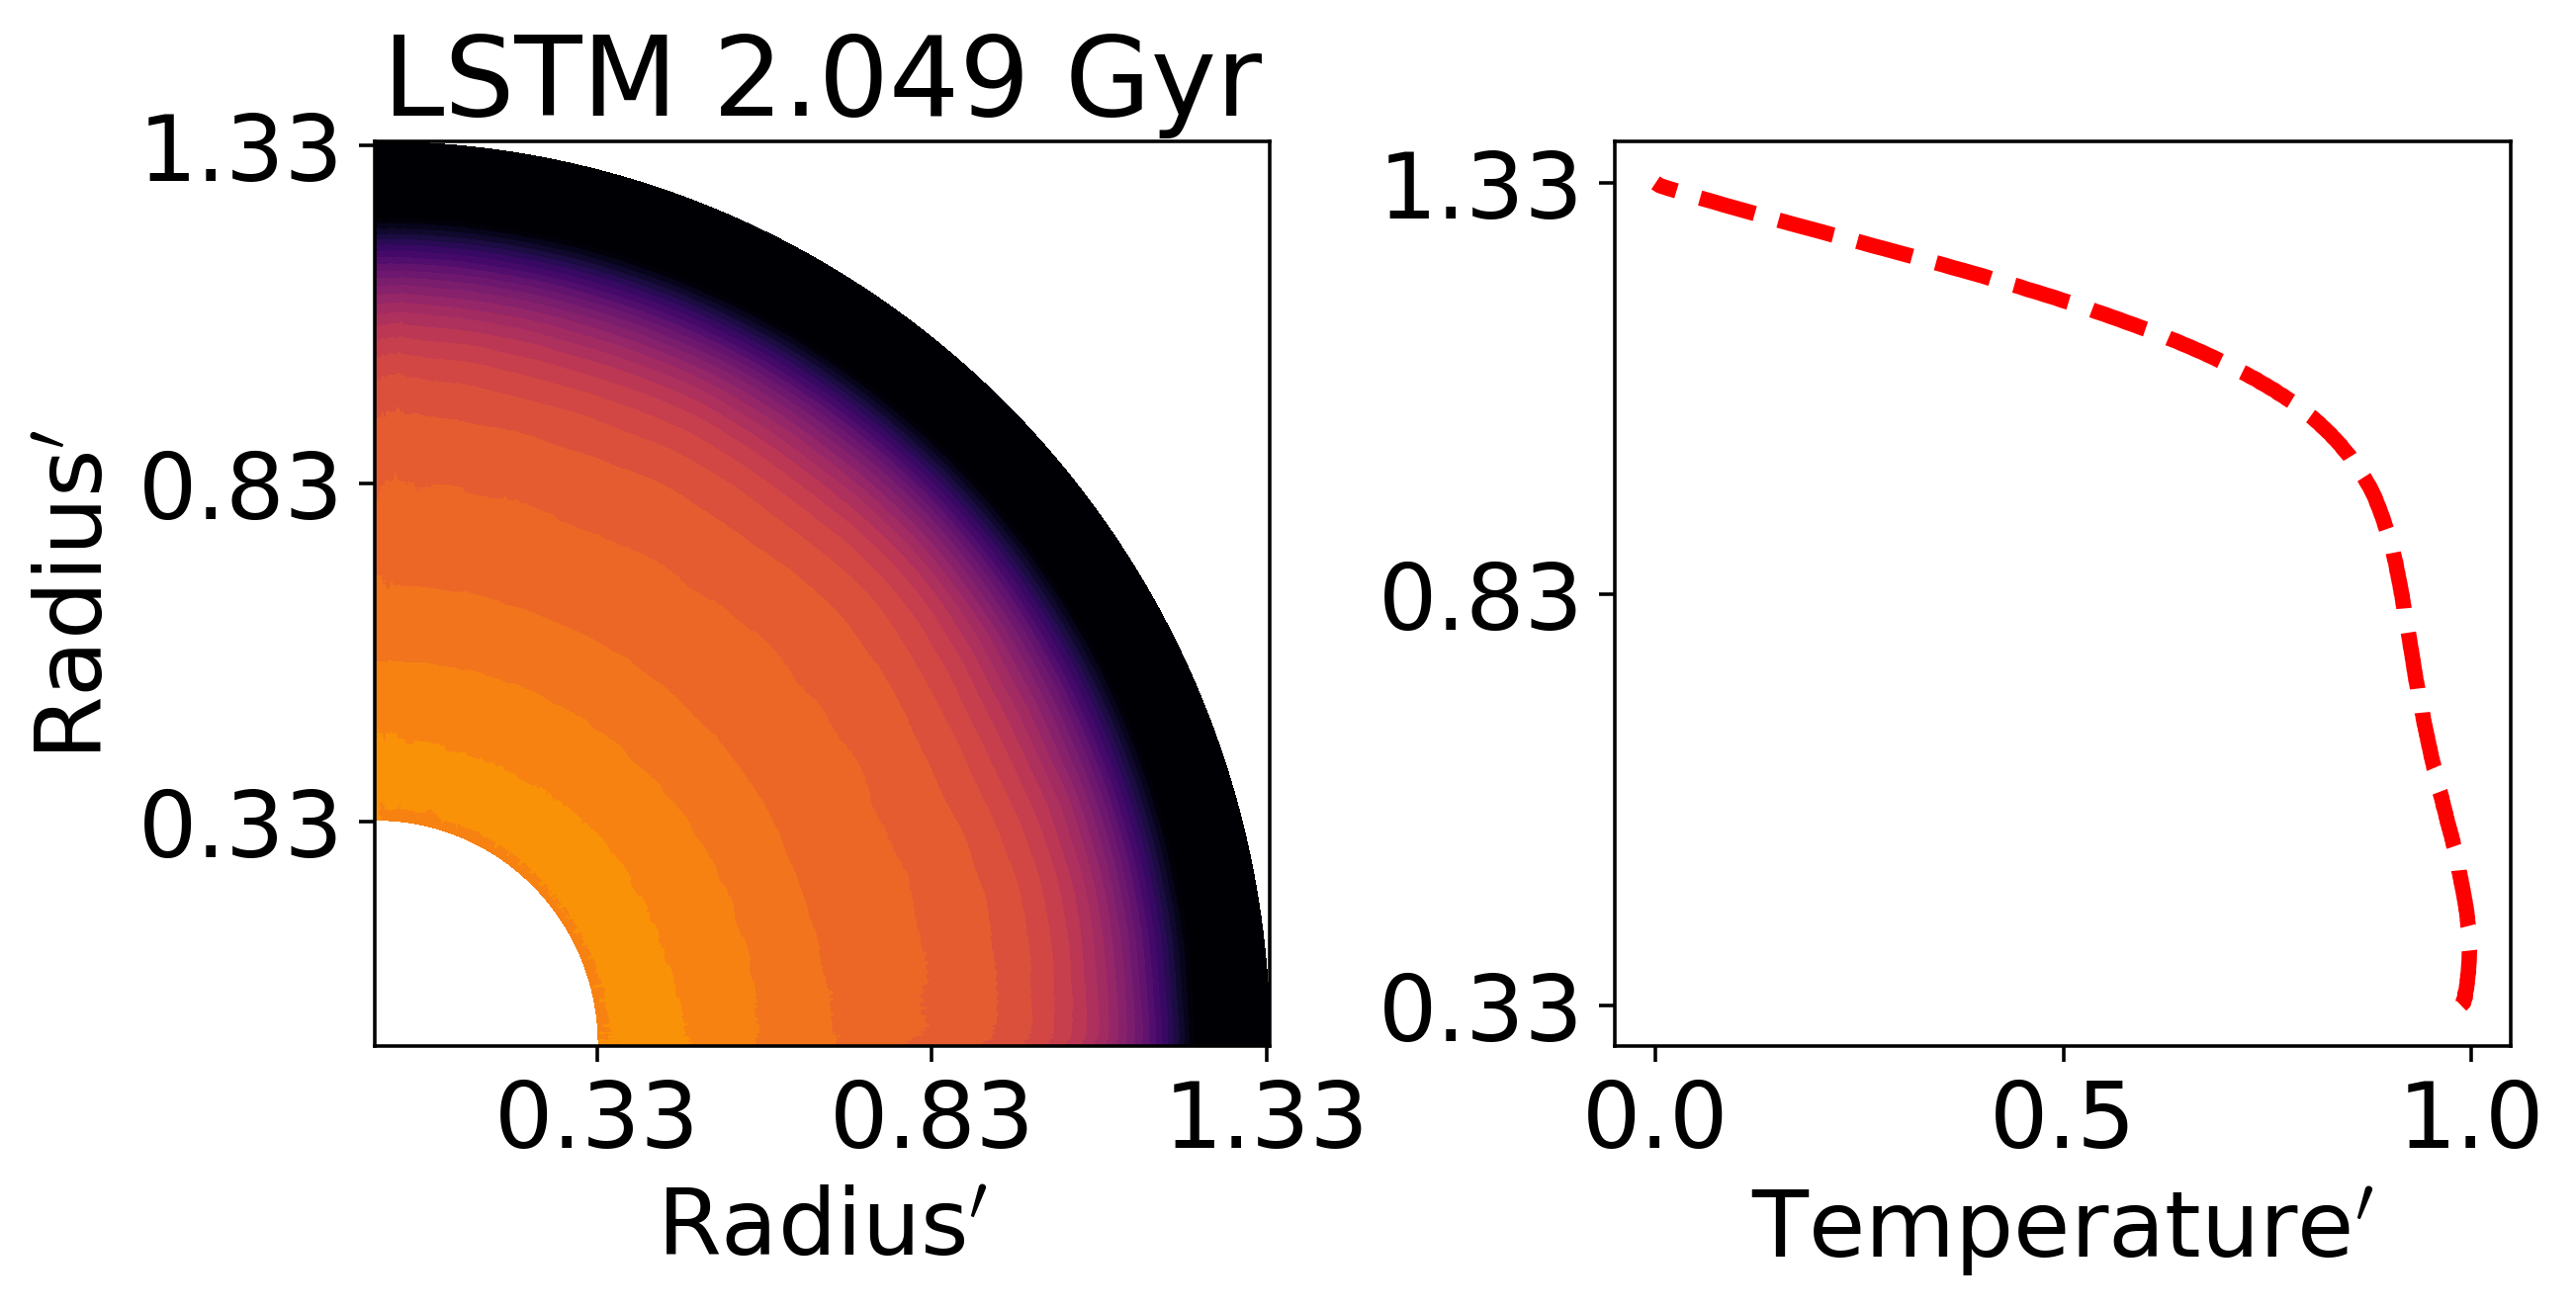

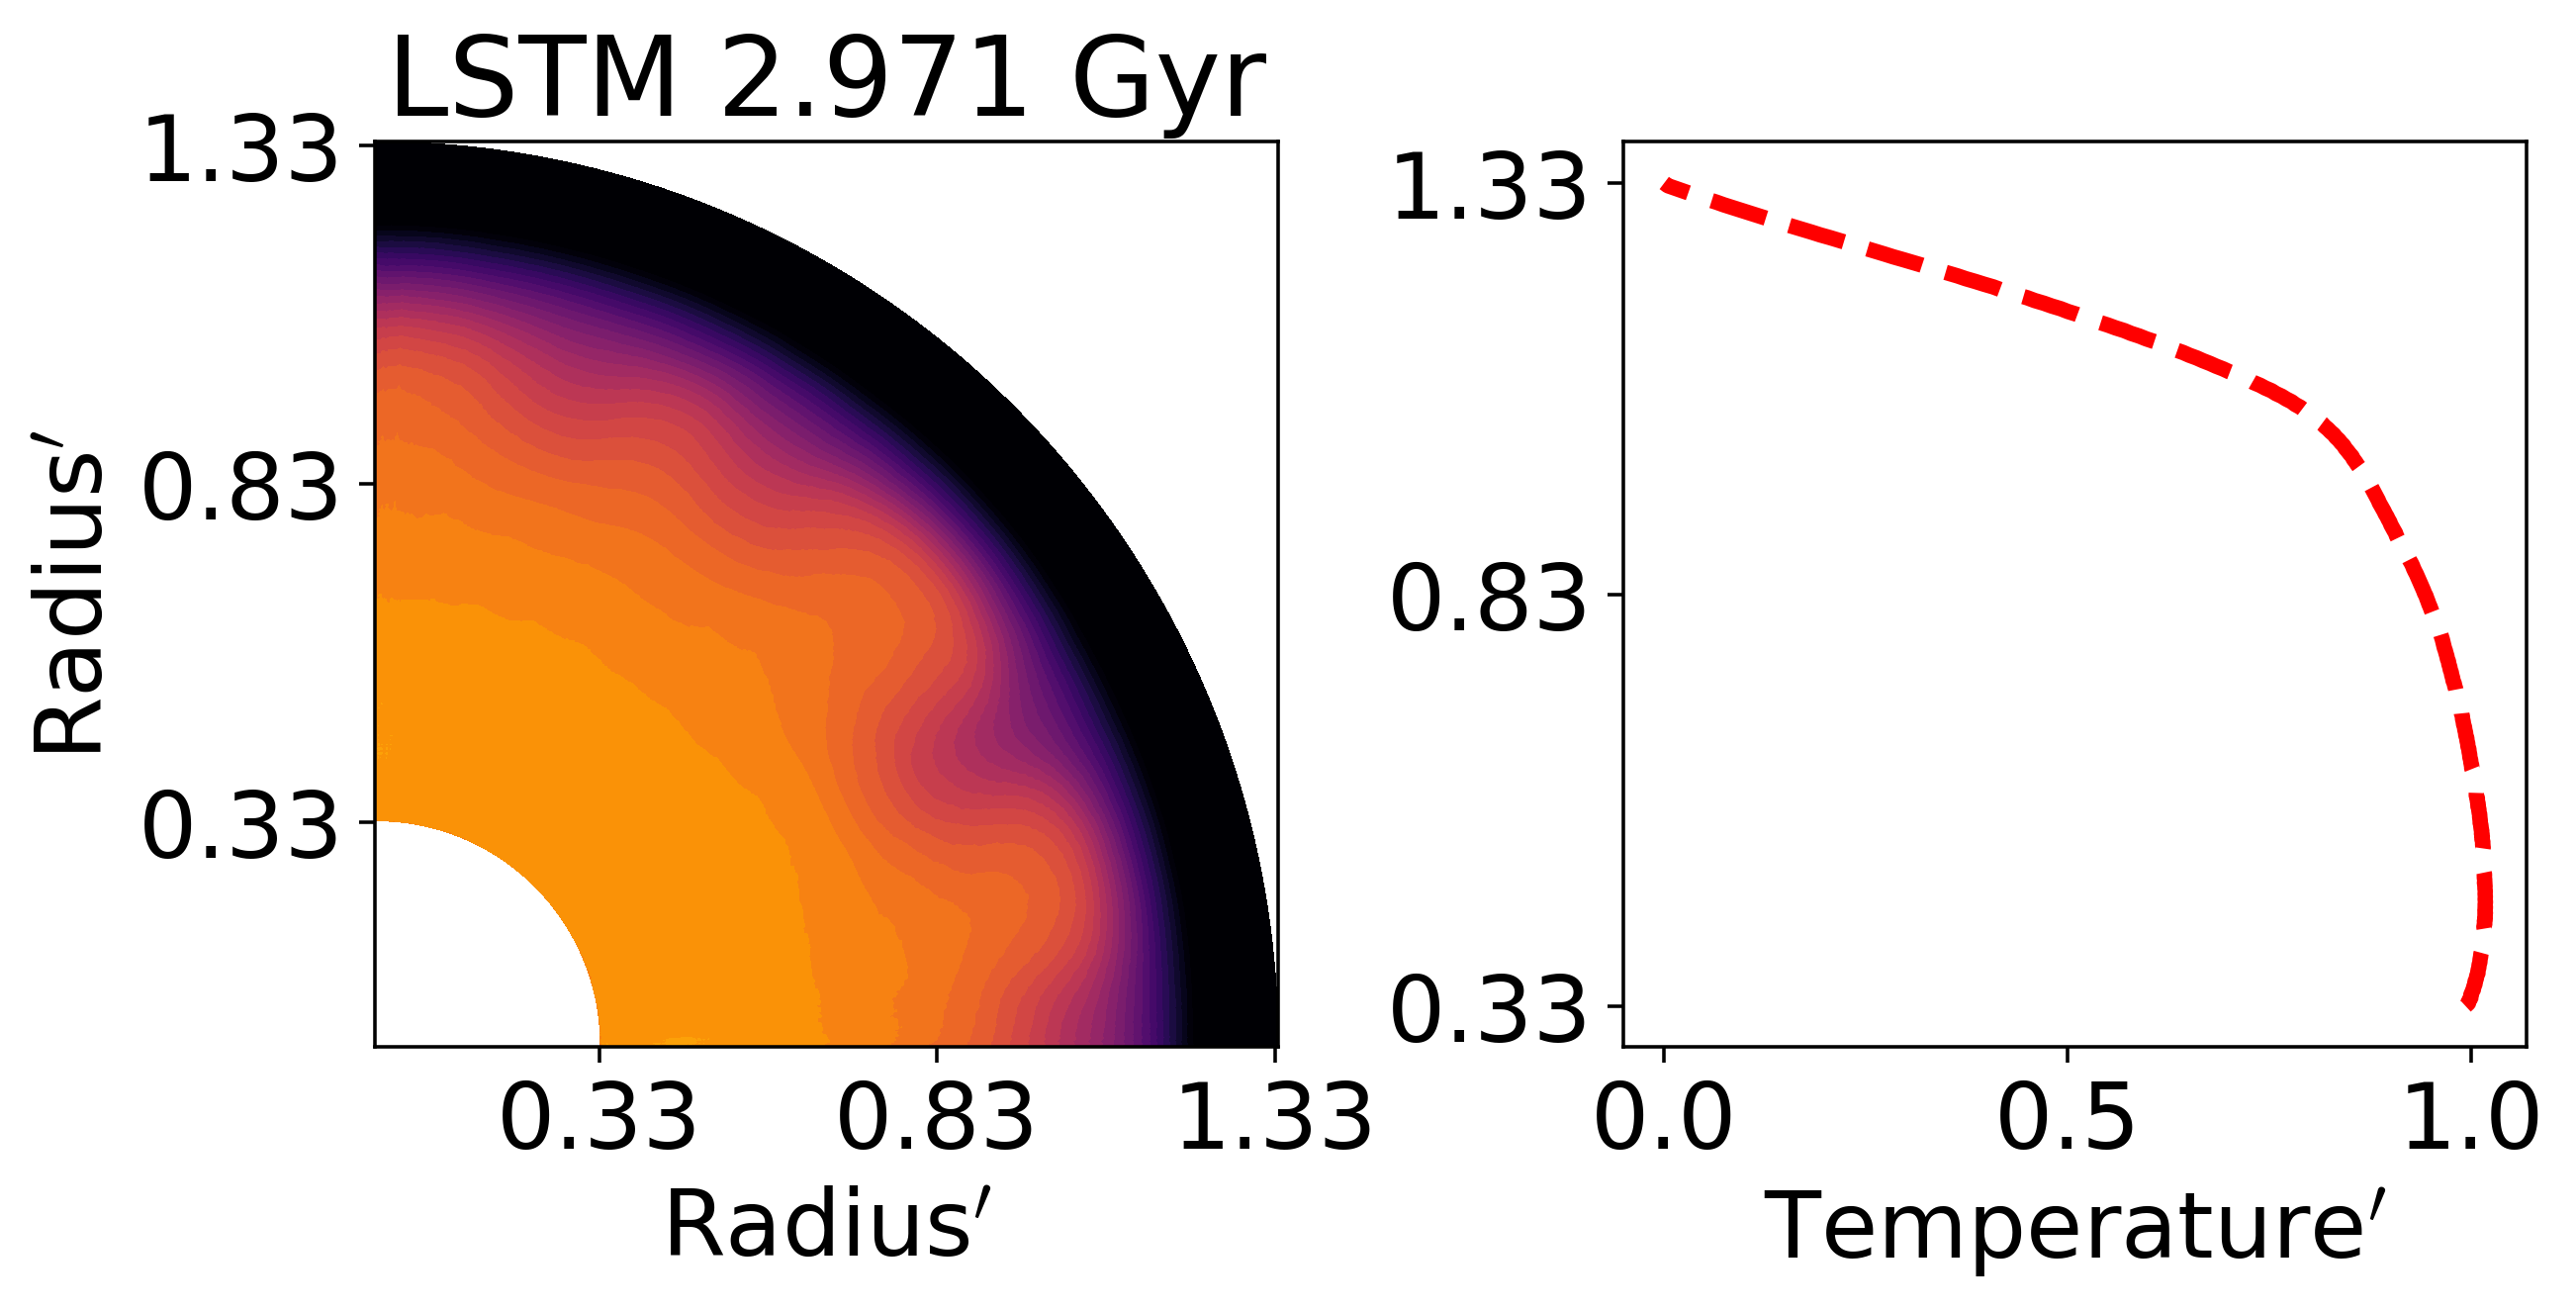

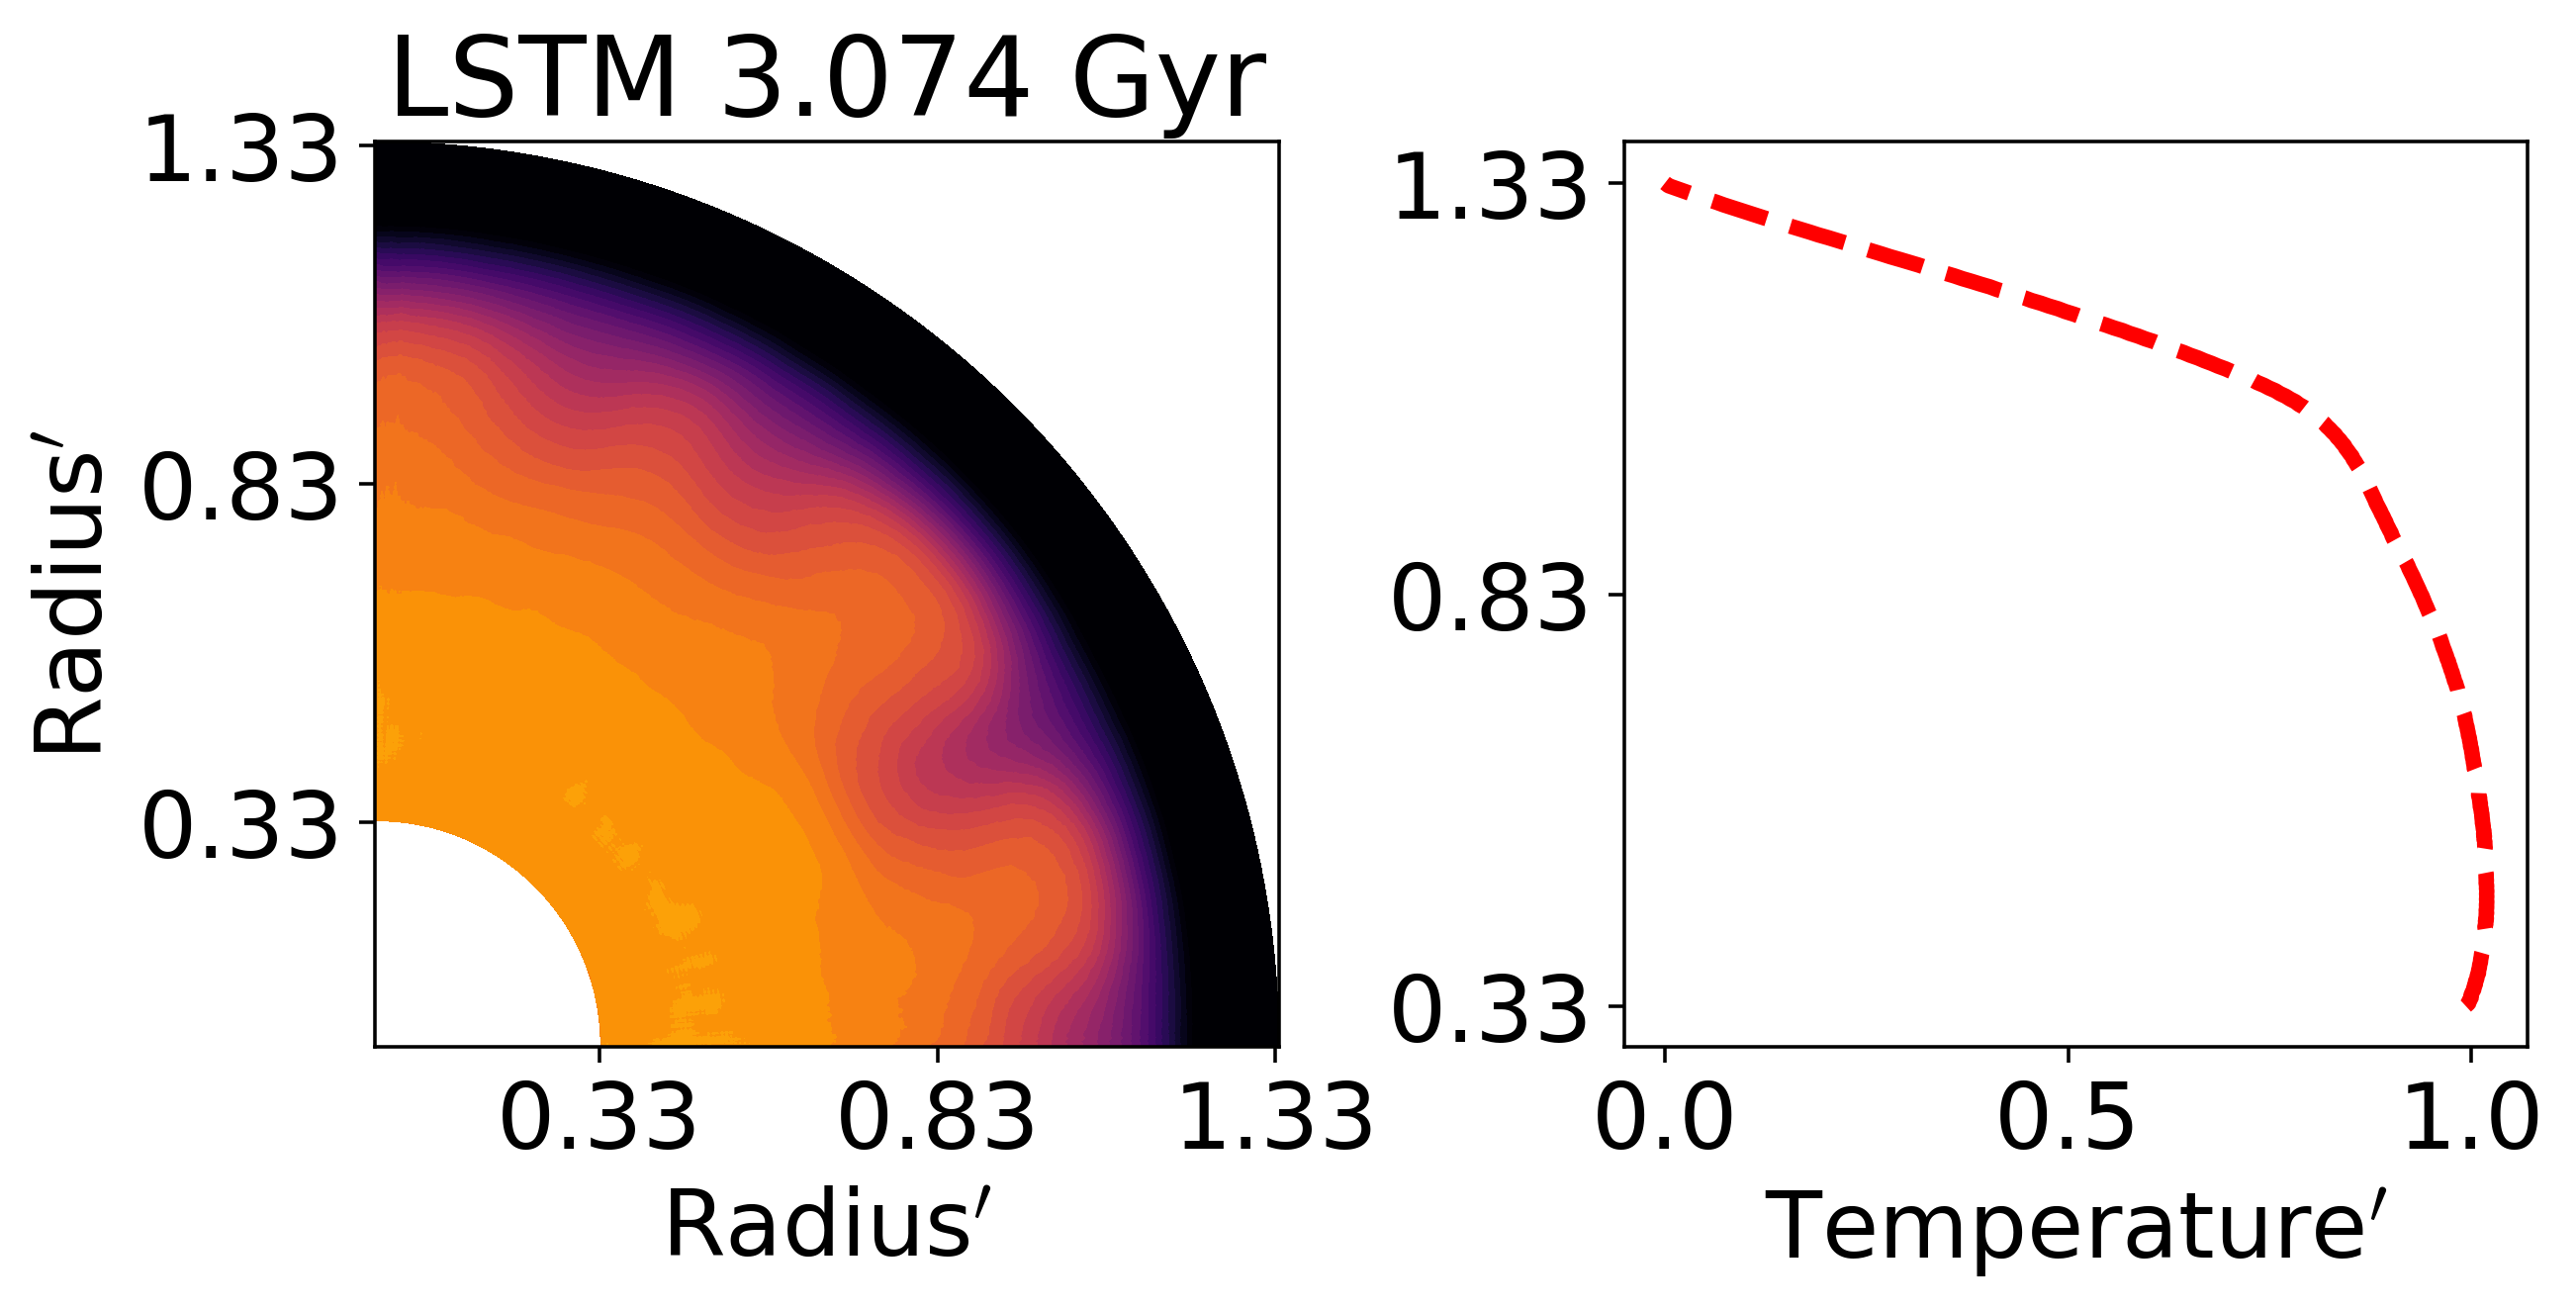

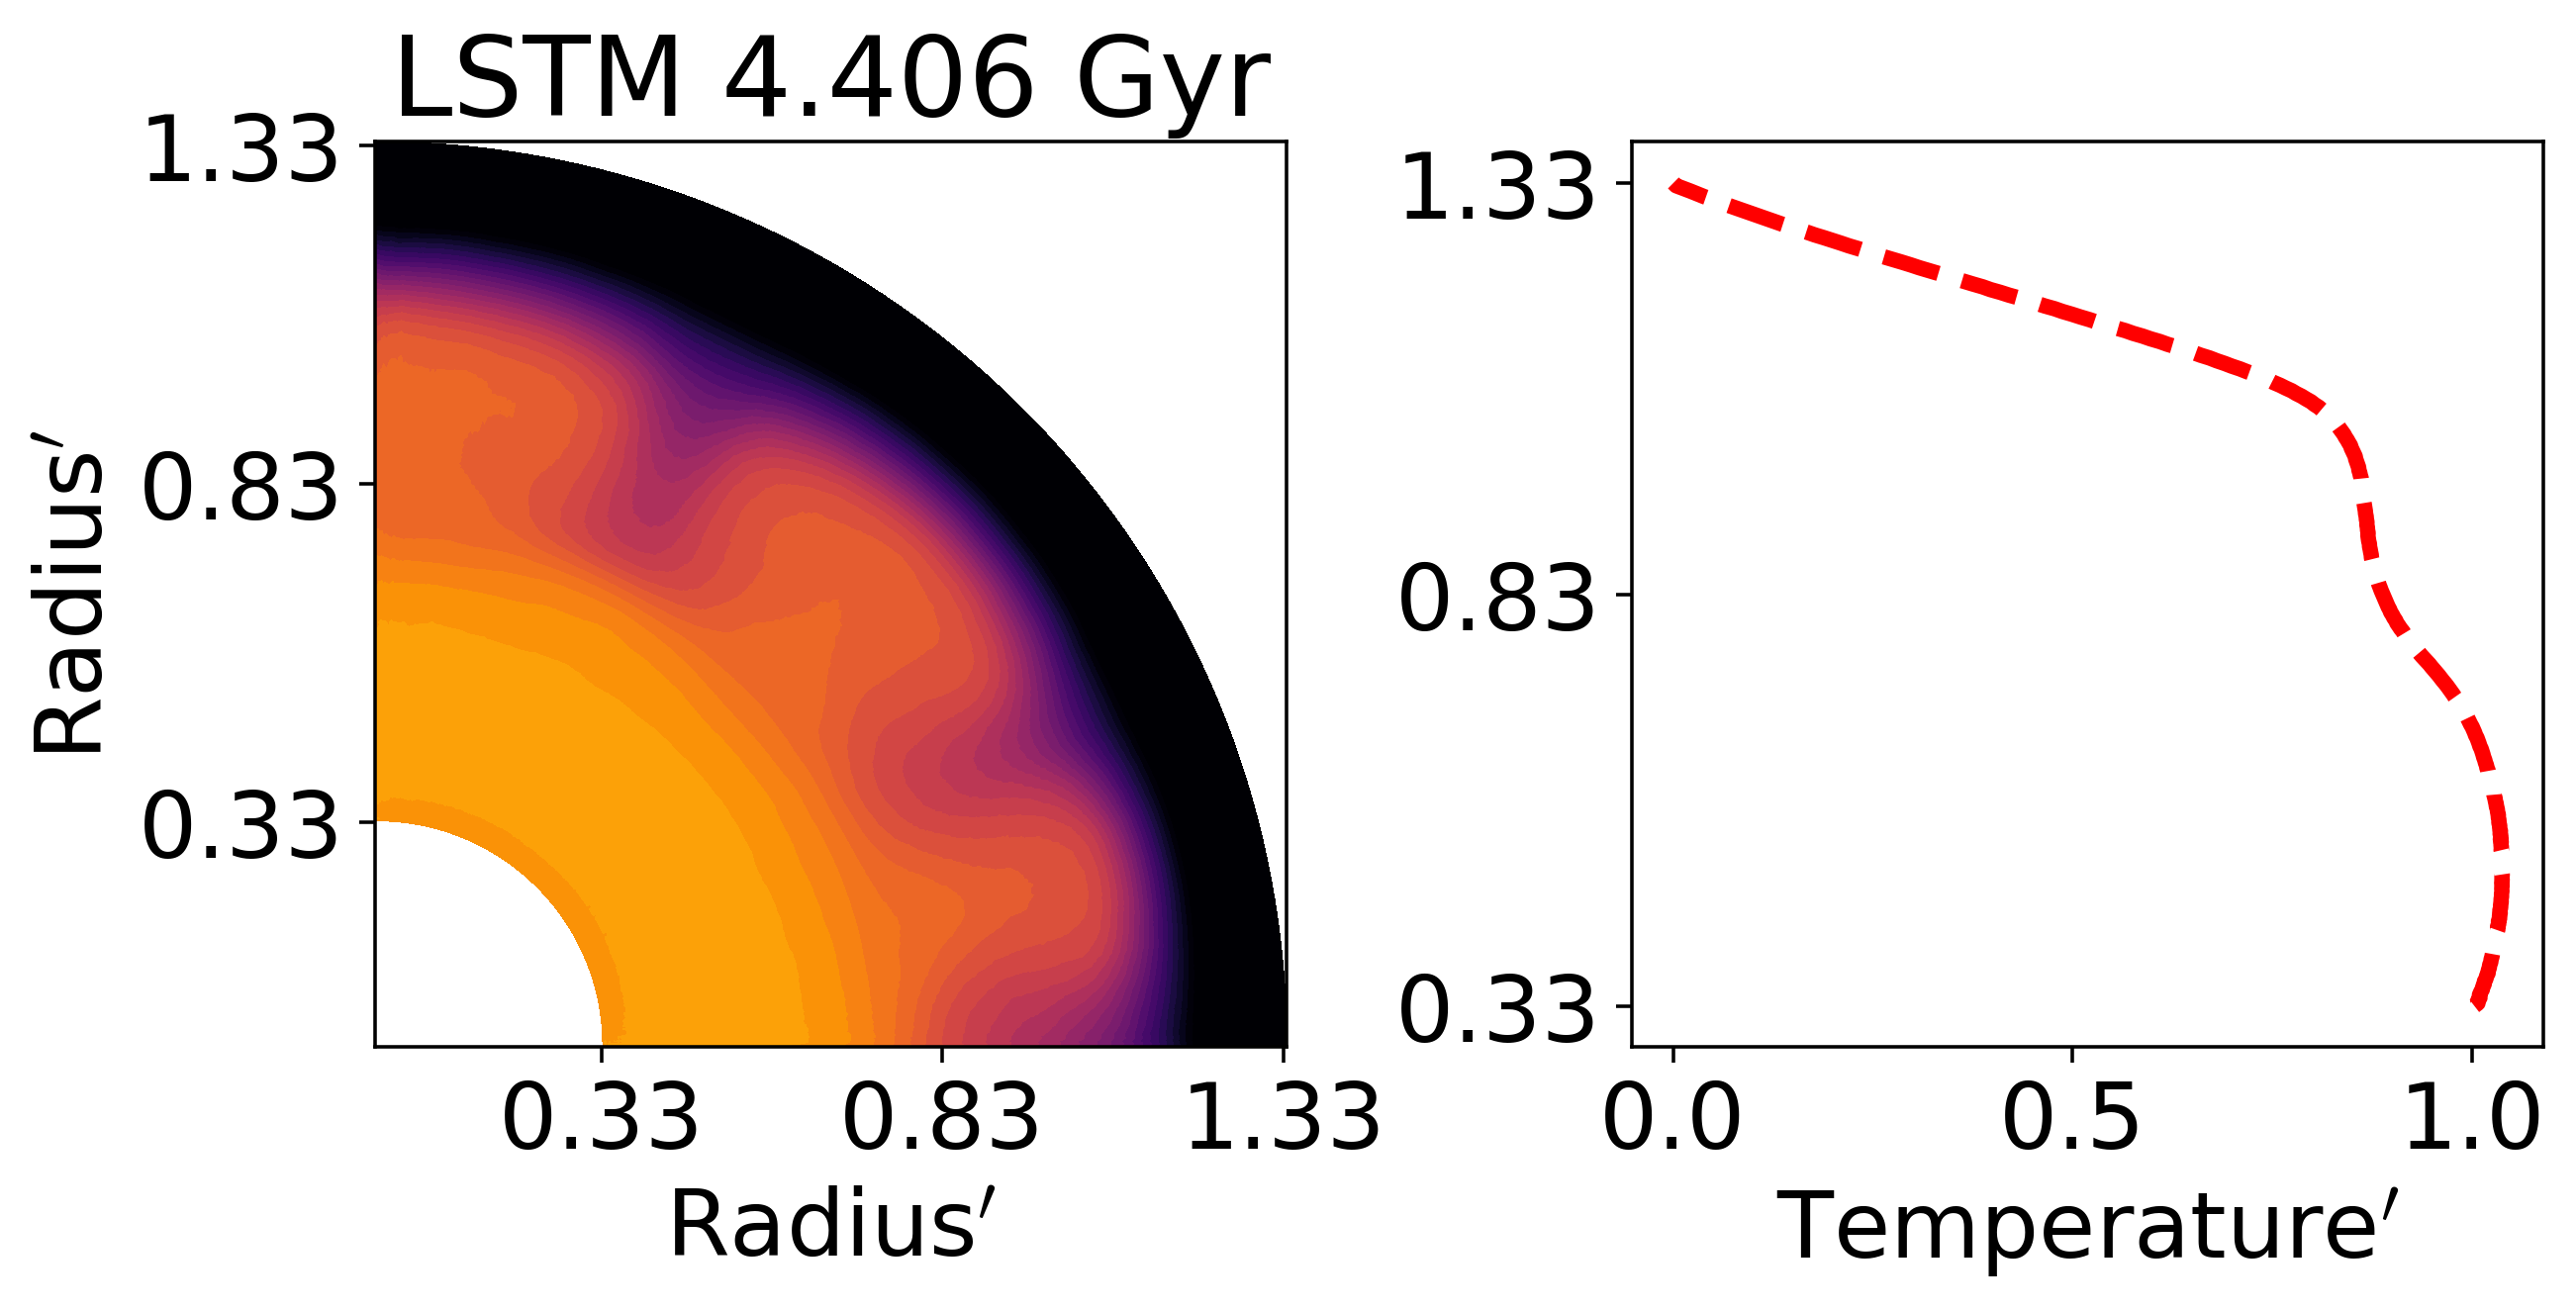

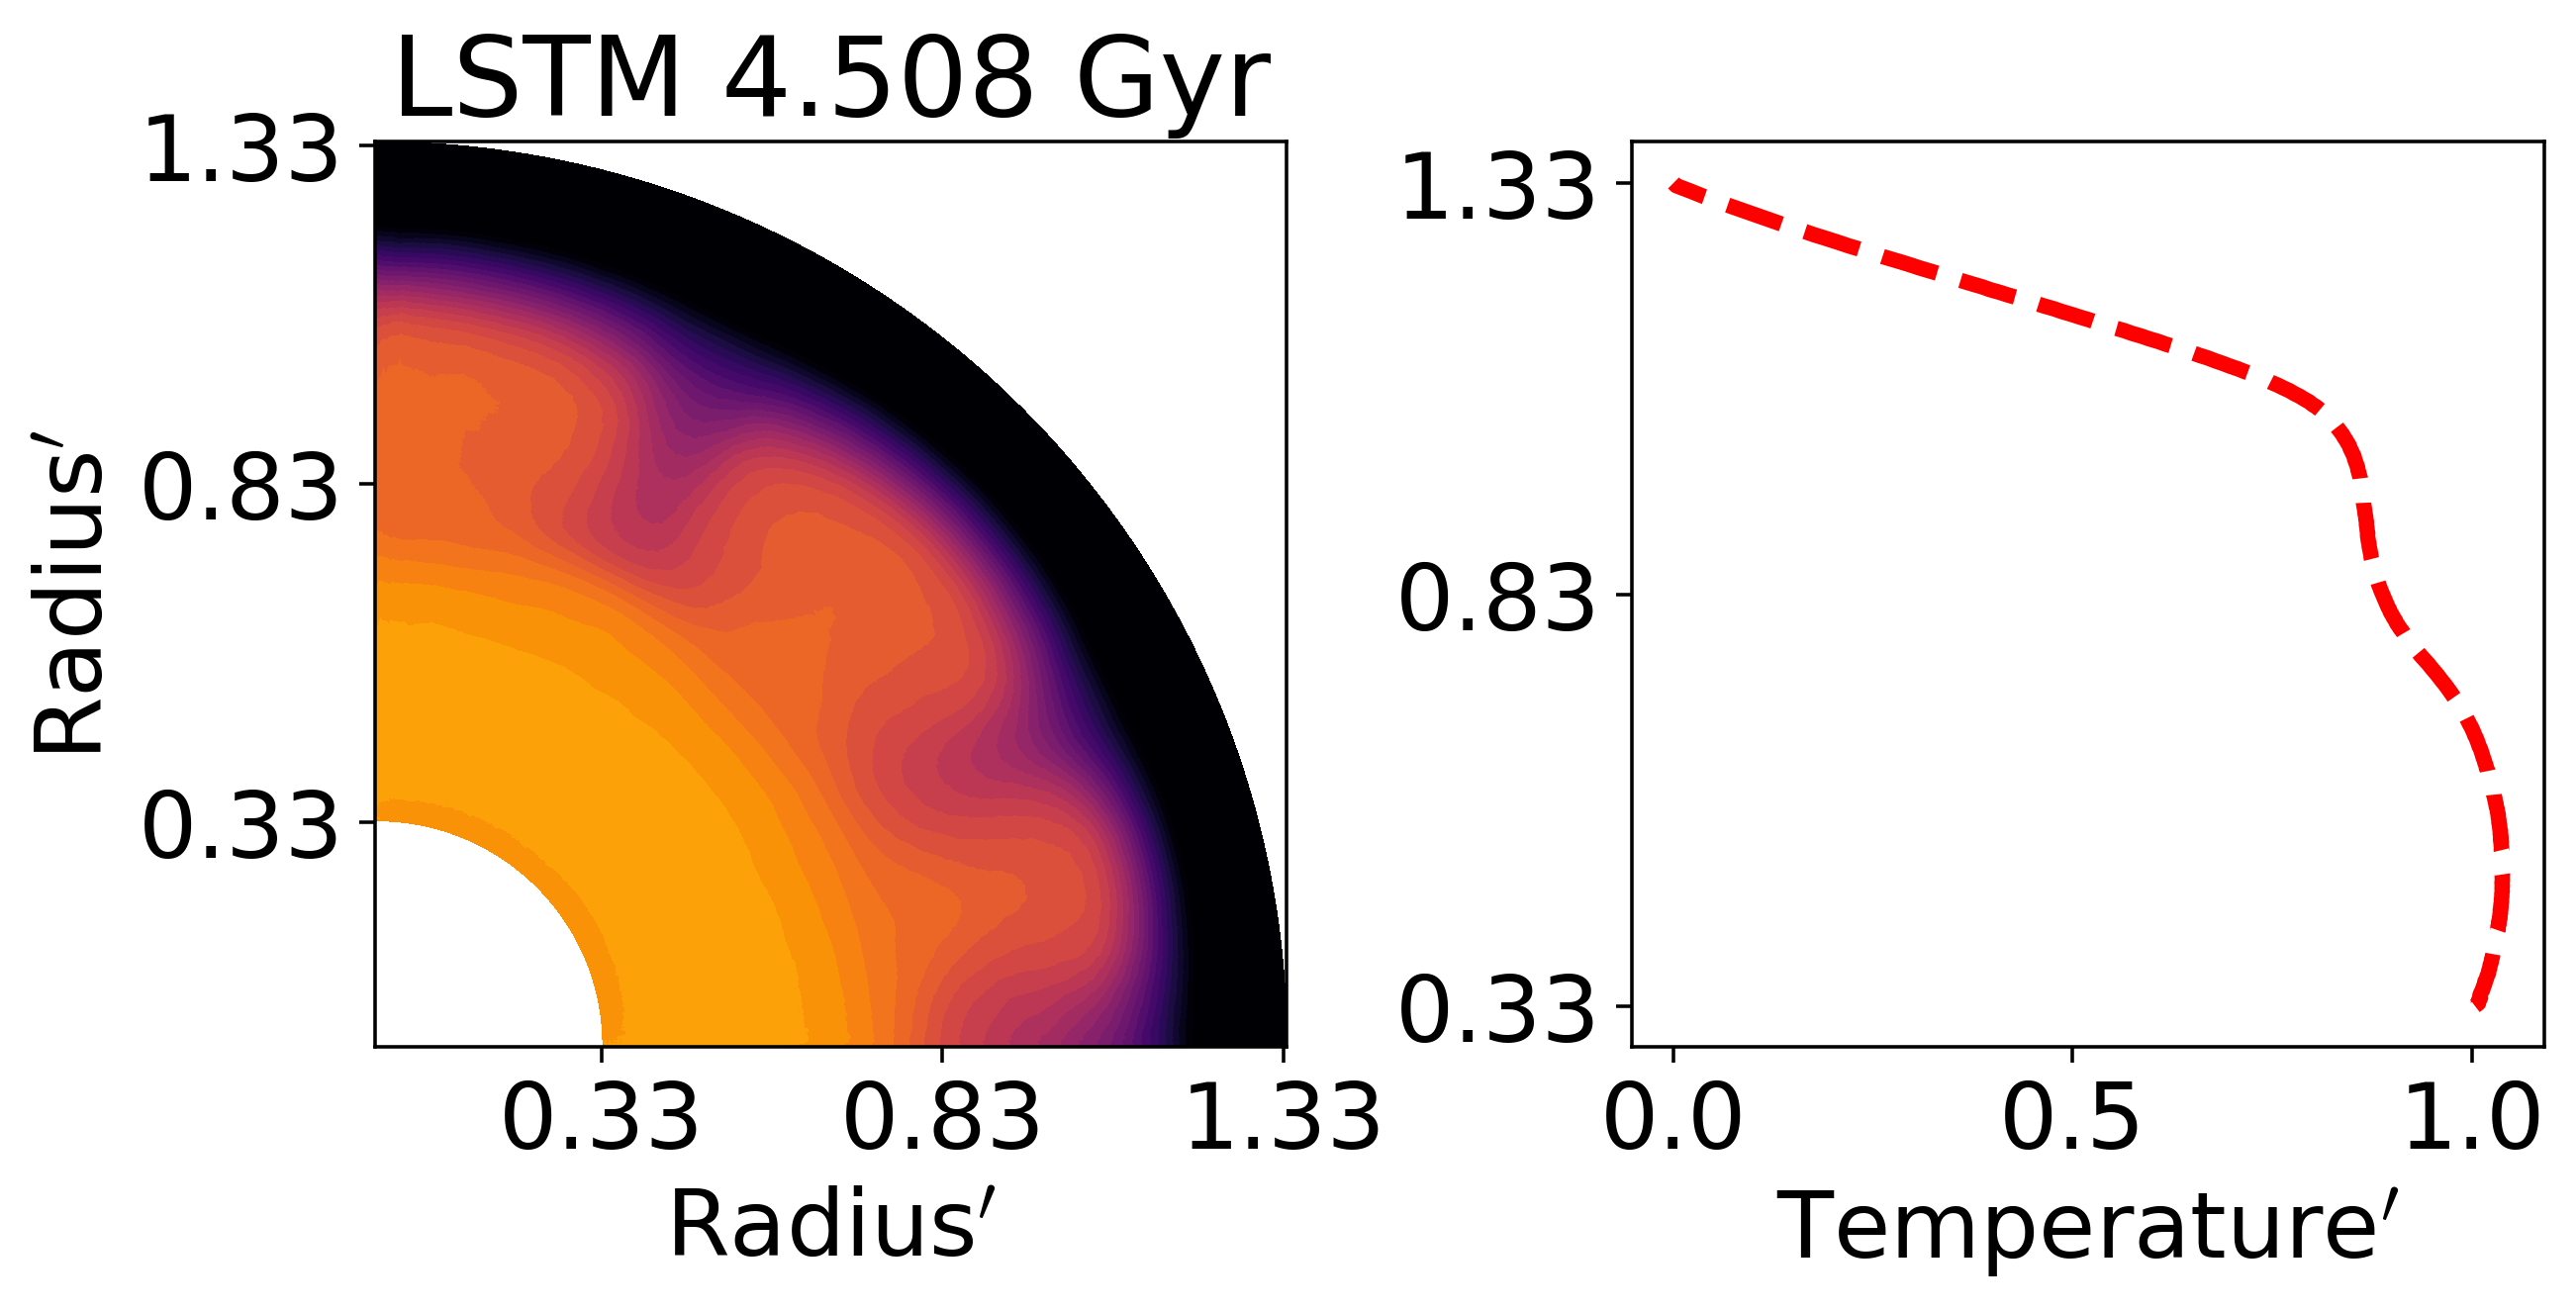

In [3]:
networkName = '[[600, 600, 600, 600], [], []]_ae840_selu_wDrpt_20to1_9877Sims_0p98tr_trial0'
parameters = []

# sim0   (First LSTM example in the paper)
parameters.append([np.power(10,21.56), 155181.30884, 4.356316962071315e-06, 15.27563, 1630])

# sim1
parameters.append([np.power(10,21.56), 155181.30884, 9.356316962071315e-06, 15.27563, 1630])

# sim n
#parameters.append([ eta_ref             in [1e+19,1e+22], 
#                    Eref                in [1e+5,5e+5], 
#                    Vref                in [4e-6,10e-6], 
#                    Enrichment          in [1,50], 
#                    initial Temperature in [1600,1800]])

CreateAnimation=False
CreatePlots=True

R = RegressionLSTM()
R.LSTM(networkName, parameters, CreateAnimation, CreatePlots)